In [2]:
# TODO
# HIGH PRIORITY
# make thresholding dynamic based on avg. dh/dt in bounding box
# calc off-lake dh/dt to subtract from on-lake dh/dt like SF18 to remove secular change; start by quantifying off-lake dh/dt to see if significant?
# convert polys[i].area to calc geodesic area instead
# overlay ICESat tracks to see where we see new lakes
# use CS2 served product
# overlay ATL11 data points on ATL15 interpolated data to know where data points are
# make dvdt plots have symbols for actual data points and dotted lines between
# change all plots to have km scale; make sure using np.round to get nice round tick labels
# ensure SiegfriedFricker2018_SF18outlines being plotted instead of SiegfriedFricker2018_outlines
# create mean lake outline from variable outlines
# interpolate between outlines at time resolution of passes to see if individual IS2 tracks match interpolated outlines

# MID PRIORITY
# tried variable outline code on ATL11 data
# make functions intake a list of S09 and a list of SF18 lakes to be included in plot (to create bbox around multiple lakes)
# -> may need to create new gpd dataframe that has corresponding S09 and SF18 lakes in same row that can be indexed in the function call
# create and heavily comment introductory cell on the general outline delineation procedure
# have dv/dt 2D line plots label the threshold level selected
# from lake-hydropotential.ipynb, import function 'SF18lakes_hydropot' to plot 
    # 1) hydropotential with agg plot to see if time-evolving outlines follow hydropotential contours and 
    # 2) make a time-variable plot with changing hydropotential and each time slice with its corresponding variable outline
# plots for combined Mac 4+5 and Slessor 4+5 since so close and hard to disentangle (use arg of bbox coords vs using lake name)
# when making contours, perhaps clip to buffer area around lake outline (vs. square bbox) once you know rough bounds of where off-lake extensions will be so you can clip out other nearby actvity?
# add gl to plots
# change S09SF18varoutlines_dhdvdt_anim to add buffer to ylimits that is alternative to *1.1, which doesn't work for zero (fix on others); i think i've already done this in other functions; find and put into all
# investigate why S09SF18varoutlines_dhdvdt_CS2vsIS2_anim trips on 'Mac5'
# have functions append volume change time series into a pandas data frame (and/or export to csv)
# have function add polygons to geopandas geodataframe (done in contours2polygons notebook; adopt here)
# change x-limits to start at 2nd time step, eg date_time_obj + datetime.timedelta(days=ds_sub.time.values[1]) so that vol change time series starts at left xaxis limit?
# S09SF18varoutlines_dhdvdt_CS2vsIS2_anim: should clip vmax,min to only CS2 cycs in IS2 era vs. all cycles
# make explicit bounding box coords optional arg as list to func
# Make colorbar appear horizontally and/or w/in plot like a legend? For shoreline agg plots to look more like timescale for agg outline plots: pl.colorbar(orientation="h", cax=cax); put vertical line in to indicate time slice being plotted
# S09SF18varoutlines_dhdvdt_CS2vsIS2_anim overwrites each plot (being name the same date); look into why this is happening
# change colormap limits to reflect rounded min and max instead of highest abs value of two; fix weird tick marks (?)
# some functions calc v = np.round(max_height_anom_abs), but don't end up using it; delete that code; esp. if you make colorbar asymmetric
# -> dh/dt plots should have vmax and vmin that reflect actual vs. the max of one
# clb = fig.colorbar(m, ticks=np.array([2019,2020,2021]),  cax=cax); why assign to clb; where is 'Year' label added?
# change S09 and SF18 outlines to be two shades of cyan so they are more distinguishable from black end of colormap of varoutiles or remove black portion of colormap or select different colormap that doesn't have black in it
# for storing function outputs in folders, first ensure folders are created for future users

# LOW PRIORITY
# perhaps add an empty colorbar to plots without colorbar so that size of all the plots is the same regardless of whether it has a colorbar or not
# make legend dynamic where it will include S09 citation if there is a S09 lake within the bounding box; same with SF18; perhaps with gpd.contains?
# have animations end on last frame and can pause (make into mp4 vs gif) 
# modify S09SF18varoutlines_agg_plot to also create animation building agg plot with agg plot as last frame; save animation; save last frame as separate file
# filter CS_dh to use at least 0.5/1? data point to not view highly interpolated areas (only if using Smith 2017 method)
# find faster thresholding method to use CS2 count to look at data based on a threshold of data points (only if using Smith 2017 method)

In [3]:
# Code to delineate subglacial lakes using variable outlines based on 
# ice surface height deformation contours, visualize and quantify lake 
# average dh/dt and lake dv/dt. 
#
# Written 2022-06-06 by W. Sauthoff (sauthoff@mines.edu)

In [11]:
# Import internal packages
import os

# Import external packages
import datetime
import geopandas as gpd
import math
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import animation
from matplotlib.patches import Ellipse, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from skimage import measure
import time
import xarray

# Set ffmpeg location
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

# Define data directories dependent on home environment (replace with your data directory file path(s))
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data_dir'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output'

# Define utility function
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

In [2]:
# # import CryoSat-2 data (closed-source data acquired from Ben Smith)
# CS2_data = open(script_dir + '/Smith_CS2.py')
# read_file = CS2_data.read()
# exec(read_file)

# # view data set
# CS2_dh

In [3]:
# TODO
# Import CryoTEMPO EOLIS SWATH THEMATIC GRIDDED PRODUCT
# https://cryotempo-eolis.org/gridded-product/

In [4]:
# Import ICESat-2 ATL15 Gridded Antarctic and Arctic Land Ice Height Change data product 
# https://doi.org/10.5067/ATLAS/ATL15.002
if os.getenv('HOME') == '/home/jovyan':
    # TODO: Grab ATL15 data using earthaccess or icepyx
    # s3url = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'
    # FIXME: temporary workaround
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    granule = 's3://is2view/ATLAS/ATL15/002/2019/ATL15_AA_0314_01km_002_02.nc'
    group = 'delta_h'
    ATL15_dh = rioxarray.open_rasterio(granule, group=group, masked=True)
    ATL15_dh
    
elif os.getenv('HOME') == '/Users/Wilson': 
    file = DATA_DIR + '/altimetry/ICESat2/ATL15.002-Ant/ATL15_AA_0314_01km_002_02.nc'
    ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)
    # Display xarray data set metadata
    ATL15_dh

In [5]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + '/boundaries/Depoorter2013-boundaries/scripps_antarctica_polygons_v1.shp' )

In [6]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# https://nsidc.org/data/nsidc-0593/versions/1
shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_coastline_v02.0.shp' 
moa_2009_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_groundingline_v02.0.shp' 
moa_2009_groundingline = gpd.read_file(shp)
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS-MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS-MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [7]:
# Import subglacial lake outline inventories
exec(open(SCRIPT_DIR + '/Smith2009_outlines.py').read())
exec(open(SCRIPT_DIR + '/SiegfriedFricker2018_outlines.py').read())
exec(open(SCRIPT_DIR + '/Sauthoff2023_outlines.py').read())

In [14]:
# create list of S09 lakes redelineated in SF18
S09_SF18_compare_1to1 = [['Cook_E2', 'Cook_E2'],
    ['KambTrunk_1', 'KT1'],
    ['Macayeal_1', 'Mac1'],
    ['Macayeal_2', 'Mac2'],
    ['Mercer_1', 'Lake78'],
    ['Mercer_2', 'MercerSubglacialLake'],
    ['Recovery_3', 'Rec2'],
    ['Recovery_4', 'Rec3'],
    ['Recovery_5', 'Rec4'], 
    ['Recovery_6', 'Rec5'],
    ['Recovery_7', 'Rec6'],
    ['Recovery_9', 'Rec8'],
    ['Recovery_10', 'Rec9'],
    ['Recovery_11', 'Rec10'],     
    ['Whillans_1', 'EngelhardtSubglacialLake'],            
    ['Whillans_2a', 'Lake12'],
    ['Whillans_2b', 'Lake10'],
    ['Whillans_3', 'WhillansSubglacialLake'],
    ['Whillans_4', 'ConwaySubglacialLake'],
    ['Whillans_5', 'UpperSubglacialLakeConway']]

In [15]:
# create list of two S09 lakes converted to one SF18 lake
S09_SF18_compare_2to1 = [['Slessor_2', 'Slessor_3', 'Slessor_23'],
    ['Recovery_1', 'Recovery_2', 'Rec1']]

In [16]:
# create list of one S09 lake converted to two SF18 lakes
S09_SF18_compare_1to2 = [['Macayeal_3', 'Mac4', 'Mac5']]

# Introduction to time-variable outline delineation method

In [ ]:
# Code explaining method here

# Func S09SF18S23_dhdt_height_thresholds_plot_anim

In [43]:
# Download a static FFmpeg build and add it to PATH.
exist = !which ffmpeg
if not exist:
  !curl https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz -o ffmpeg.tar.xz \
     && tar -xf ffmpeg.tar.xz && rm ffmpeg.tar.xz
  ffmdir = !find . -iname ffmpeg-*-static
  path = %env PATH
  path = path + ':' + ffmdir[0]
  %env PATH $path
print('')
!which ffmpeg
print('Done!')


/Users/Wilson/opt/anaconda3/envs/lakeshores/bin/ffmpeg
Done!


In [3]:
import cv2
import os

image_folder = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/plot'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [39]:
# changing output to mp4 instead of gif

def S09SF18S23_dhdt_height_thresholds_plot_anim(lakename_S23, buffer, thres, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes in bounding box created using geopandas buffer around known lakes outlines
    in Siegfried and Fricker, 2018 inventory and lake points in Livingstone and others, 2023 (collated in Sauthoff2023_outlines inventory).
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. Plots the pos./neg.
    thresholds input.
    Inputs: 
        lakename: lake of interest from Sauthoff2023_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate time-variable lake boundary.
    '''
    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    
    # Subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
        # max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    # v = np.round(max_height_anom_abs) # TODO: plot asymetric colorbar to show true scale of change
    
    # Create fig, ax, colorbar
    fig, ax = plt.subplots(figsize=(8,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    # if dataset.fileName == 'mos_2010.5_2021.5.h5':
    #             ani.setup(fig, OUTPUT_DIR + 
    #               '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_height_thresholds_anim-{}-{}.gif'
    #               .format(lakename_S23, 'CS2'), dpi=300)
    # elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
    #     with writer.saving(fig, OUTPUT_DIR + 
    #               '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_height_thresholds_anim-{}-{}.mp4'
    #               .format(lakename_S23, 'IS2'), dpi=300): 

    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_height_thresholds_anim-{}-{}.gif'
                  .format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_height_thresholds_anim-{}-{}.gif'
                  .format(lakename_S23, 'IS2'), dpi=300)
    
    # Create empty list to store dates
    dates = []
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # Calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
    
        # Create difference from one acquisition cycle to the next
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
    
        # Establish diverging colorbar
        divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
    
        # Plot figure
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap='RdBu', norm=divnorm)
        # Create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        for thres_i in thres:     
            contour = measure.find_contours(dhdt.values, thres_i)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres_i)
            if len(contour) > 0: 
                contours_drain += [contour]
        
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        
        # Plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:,1]*x_conv, y_max-contours_fill[i][j][:,0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=1)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:,1]*x_conv, y_max-contours_drain[i][j][:,0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
        
        # Label axes
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
        
        # Add title and colorbar
        ax.set_title(lakename_S23+' dh + outline comparison \nh$_{'+newdate1.strftime('%m/%Y')+'}$ - h$_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)
        
        # Overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        
        # Create legend
        ax.legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')
        
        # Plot inset map to show location 
        axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')
    
        # Save fig
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/plot/S09SF18S23_dhdt_height_thresholds_plot-{}-{}-{}.png'
                        .format(lakename_S23,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/plot/S09SF18S23_dhdt_height_thresholds_plot-{}-{}-{}.png'
                        .format(lakename_S23,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")      
        
        # Append image to animation list
        ani.grab_frame()
        # Clear axis to create next plot
        ax.clear()
    
    # Finish animation and close fig
    ani.finish()
    plt.close()

TypeError: 'list' object is not callable

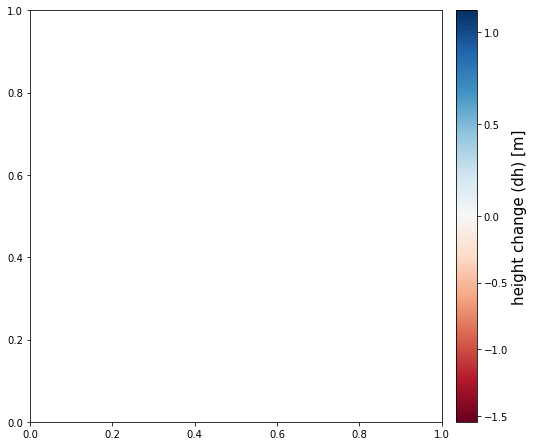

In [35]:
# Test function working using one lake
# S09SF18S23_dhdt_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, [0.2, 0.4, 0.6, 0.8], CS2_dh)
# S09SF18S23_dhdt_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, [0.2, 0.4, 0.6, 0.8], ATL15_dh)
# S09SF18S23_dhdt_height_thresholds_plot_anim('Lambert_1', 10000, [0.2, 0.4, 0.6, 0.8], CS2_dh)
# S09SF18S23_dhdt_height_thresholds_plot_anim('Lambert_1', 10000, [0.25, 0.5, 0.75], ATL15_dh)
S09SF18S23_dhdt_height_thresholds_plot_anim('Thw_70', 10000, [1.0], ATL15_dh)

In [118]:
def S09SF18S23_dhdt_height_thresholds_plot_anim(lakename_S23, buffer, thres, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes in bounding box created using geopandas buffer around known lakes outlines
    in Siegfried and Fricker, 2018 inventory and lake points in Livingstone and others, 2023 (collated in Sauthoff2023_outlines inventory).
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. Plots the pos./neg.
    thresholds input.
    Inputs: 
        lakename: lake of interest from Sauthoff2023_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate time-variable lake boundary.
    '''
    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    
    # Subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
        # max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    # v = np.round(max_height_anom_abs) # TODO: plot asymetric colorbar to show true scale of change
    
    # Create fig, ax, colorbar
    fig, ax = plt.subplots(figsize=(8,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    # Create empty list to store animation images
    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_height_thresholds_anim-{}-{}.gif'
                  .format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_height_thresholds_anim-{}-{}.gif'
                  .format(lakename_S23, 'IS2'), dpi=300)
    
    # Create empty list to store dates
    dates = []
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # Calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
    
        # Create difference from one acquisition cycle to the next
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
    
        # Establish diverging colorbar
        divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
    
        # Plot figure
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap='RdBu', norm=divnorm)
        # Create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        for thres_i in thres:     
            contour = measure.find_contours(dhdt.values, thres_i)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres_i)
            if len(contour) > 0: 
                contours_drain += [contour]
        
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        
        # Plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:,1]*x_conv, y_max-contours_fill[i][j][:,0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=1)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:,1]*x_conv, y_max-contours_drain[i][j][:,0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
        
        # Label axes
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
        
        # Add title and colorbar
        ax.set_title(lakename_S23+' dh + outline comparison \nh$_{'+newdate1.strftime('%m/%Y')+'}$ - h$_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)
        
        # Overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        
        # Create legend
        ax.legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')
        
        # Plot inset map to show location 
        axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')
       
        # Save fig
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/plot/S09SF18S23_dhdt_height_thresholds_plot-{}-{}-{}.png'
                        .format(lakename_S23,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_height_thresholds_plot_anim/plot/S09SF18S23_dhdt_height_thresholds_plot-{}-{}-{}.png'
                        .format(lakename_S23,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")      
        
        # Append image to animation list
        ani.grab_frame()
        ax.clear()
    
    # Finish animation and close fig
    ani.finish()
    plt.close()

In [119]:
# Test function working using one lake
# S09SF18S23_dhdt_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, [0.2, 0.4, 0.6, 0.8], CS2_dh)
# S09SF18S23_dhdt_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, [0.2, 0.4, 0.6, 0.8], ATL15_dh)
# S09SF18S23_dhdt_height_thresholds_plot_anim('Lambert_1', 10000, [0.2, 0.4, 0.6, 0.8], CS2_dh)
# S09SF18S23_dhdt_height_thresholds_plot_anim('Lambert_1', 10000, [0.25, 0.5, 0.75], ATL15_dh)
S09SF18S23_dhdt_height_thresholds_plot_anim('Thw_70', 10000, [1.0], ATL15_dh)

In [ ]:
# Run func on all lakes from S23 inventory
for idx in range(len(Sauthoff2023_outlines)-1):
    lakename = Sauthoff2023_outlines['name'][idx]
    S09SF18S23_dhdt_height_thresholds_plot_anim(lakename, 7500, [0.25, 0.5, 0.75], CS2_dh)
    S09SF18S23_dhdt_height_thresholds_plot_anim(lakename, 7500, [0.25, 0.5, 0.75], ATL15_dh)

# Func S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim

In [113]:
def S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim(lakename_S23, buffer, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes in bounding box created using geopandas buffer around known lakes outlines
    in Siegfried and Fricker, 2018 inventory and lake points in Livingstone and others, 2023 (collated in Sauthoff2023_outlines inventory).
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. Plots the pos./neg.
    threshold using a dynamic method based on the height change range of that region.
    Inputs: 
        lakename: lake of interest from Sauthoff2023_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate 
        time-variable lake outline.
    '''
    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

    # Subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
   
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    # Create empty lists to store data
    height_anom_pos = []
    height_anom_neg = []
    dhdt_das = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
        dhdt_da = ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:]
        dhdt_das.append(dhdt_da)
    dhdt_ds = xarray.concat(dhdt_das, dim='delta_h')
   
    # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    
    # Create dynamic threshold based on height change range
    thres = 2 * np.mean(abs(dhdt_ds)).values
   
    # Create fig, ax, colorbar
    fig, ax = plt.subplots(figsize=(8,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
   
    # Create empty list to store animation images
    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_dynamic_height_thresholds_anim-{}-{}.gif'
                  .format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim/anim/S09SF18S23_dhdt_dynamic_height_thresholds_anim-{}-{}.gif'
                  .format(lakename_S23, 'IS2'), dpi=300)
   
    # Create empty list to store dates
    dates = []
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # Calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
   
        # Create difference from one acquisition cycle to the next
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
   
        # Establish diverging colorbar
        divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
   
        # Plot figure
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap='RdBu', norm=divnorm)
   
        # Create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
   
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
   
        # Plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:,1]*x_conv, y_max-contours_fill[i][j][:,0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=1)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:,1]*x_conv, y_max-contours_drain[i][j][:,0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
   
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
   
        # Label axes
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
   
        # Add title and colorbar
        ax.set_title(lakename_S23+' dh + outline comparison \nh$_{'+newdate1.strftime('%m/%Y')+'}$ - h$_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)
   
        # Overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
   
        # Create legend
        ax.legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+ '+str(np.round(thres,1))+' m uplift (filling) variable outline'), '– '+str(np.round(thres,1))+' m subsidence (draining) variable outline'], 
            loc='upper left')
       
        # Plot inset map to show location 
        axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2009_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2009_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')
       
        # Save fig
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim/plot/S09SF18S23_dhdt_dynamic_height_thresholds_plot-{}-{}-{}.png'
                        .format(lakename_S23,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim/plot/S09SF18S23_dhdt_dynamic_height_thresholds_plot-{}-{}-{}.png'
                        .format(lakename_S23,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")      
        
        # Append image to animation list
        ani.grab_frame()
        ax.clear()
    
    # Finish animation and close fig
    ani.finish()
    plt.close()

In [115]:
# Test function working using one lake
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, CS2_dh)
S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Lambert_1', 10000, CS2_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Lambert_1', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_70', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_124', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_142', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_170', 10000, ATL15_dh)

In [52]:
# Run func on all lakes from S23 inventory
for idx in range(len(Sauthoff2023_outlines)-1):
    lakename = Sauthoff2023_outlines['name'][idx]
    # S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim(lakename, 7500, CS2_dh)
    S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim(lakename, 7500, ATL15_dh)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

# Func S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim

In [111]:
def S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim(lakename_S23, surrounding_area_multiple, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes in bounding box created using geopandas buffer around known lakes outlines
    in Siegfried and Fricker, 2018 inventory and lake points in Livingstone and others, 2023 (collated in Sauthoff2023_outlines inventory).
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. Plots the pos./neg.
    threshold using a dynamic method based on the height change range of that region.
    Inputs: 
        lakename: lake of interest from Sauthoff2023_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate 
        time-variable lake outline.
    '''
    # Isolate individual lake and find scene area based on lake area
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_area = lake_gpd['area (m^2)']
    scene_area = surrounding_area_multiple * lake_area
    scene_side_length = math.sqrt(scene_area)

    # Define lake bounding box
    x_min = lake_gpd.geometry.centroid.x.values[0] - 0.5 * scene_side_length
    x_max = lake_gpd.geometry.centroid.x.values[0] + 0.5 * scene_side_length
    y_min = lake_gpd.geometry.centroid.y.values[0] - 0.5 * scene_side_length
    y_max = lake_gpd.geometry.centroid.y.values[0] + 0.5 * scene_side_length

    # Subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
 
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    # Create empty lists to store data
    height_anom_pos = []
    height_anom_neg = []
    dhdt_das = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
        dhdt_da = ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:]
        dhdt_das.append(dhdt_da)
    dhdt_ds = xarray.concat(dhdt_das, dim='delta_h')
    
    # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    
    # Create dynamic threshold based on height change range
    thres = 2 * np.mean(abs(dhdt_ds)).values
    
    fig, ax = plt.subplots(figsize=(8,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    # Create empty list to store animation images
    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim/anim/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_anim-{}-{}.gif'
                  .format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim/anim/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_anim-{}-{}.gif'
                  .format(lakename_S23, 'IS2'), dpi=300)
   
    # Create empty list to store dates
    dates = []
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # Calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        
        # Create difference from one acquisition cycle to the next
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        
        # Establish diverging colorbar
        divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
        
        # Plot figure
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap='RdBu', norm=divnorm)
        
        # Create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        
        # Plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:,1]*x_conv, y_max-contours_fill[i][j][:,0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=1)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:,1]*x_conv, y_max-contours_drain[i][j][:,0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                
        # Set axes limits
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
       
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
       
        # Label axes
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
       
        # Add title and colorbar
        ax.set_title(lakename_S23+' dh + outline comparison \nh$_{'+newdate1.strftime('%m/%Y')+'}$ - h$_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)
       
        # Overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
                
        # Create legend
        ax.legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+ '+str(np.round(thres,1))+' m uplift (filling) variable outline'), '– '+str(np.round(thres,1))+' m subsidence (draining) variable outline'], 
            loc='upper left')
        
        # Plot inset map to show location 
        axIns = ax.inset_axes([0.99, 0.99, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2009_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2009_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')
       
        # Save and close figure
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim/plot/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot-{}-{}-{}.png'
                        .format(lakename_S23,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim/plot/S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot-{}-{}-{}.png'
                        .format(lakename_S23,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")      
        
        # Append image to animation list
        ani.grab_frame()
        ax.clear()
    
    # Finish animation
    ani.finish()
    plt.close()

In [112]:
# Test function working using one lake
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('ConwaySubglacialLake', 10000, CS2_dh)
S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim('ConwaySubglacialLake', 4, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Lambert_1', 10000, CS2_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Lambert_1', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim('Thw_70', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_124', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_142', 10000, ATL15_dh)
# S09SF18S23_dhdt_dynamic_height_thresholds_plot_anim('Thw_170', 10000, ATL15_dh)

In [ ]:
# Run func on all lakes from S23 inventory
for idx in range(len(Sauthoff2023_outlines)-1):
    lakename = Sauthoff2023_outlines['name'][idx]
    # S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim(lakename, 7500, CS2_dh)
    S09SF18S23_dhdt_dynamic_height_thresholds_bbox_area_plot_anim(lakename, 7500, ATL15_dh)

# Func S09SF18S23_dhdadvdt_plot_anim 

In [ ]:
def S09SF18S23_dhdadvdt_anim(lakename_S09, lakename_S23, buffer, thres, dataset): 
    '''
    Create dh/dt plots ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use time-variable outlines to calculate dv/dt.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        1x3 plots of: 
        * Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary alongside 
        * 2-D line plot of dArea and
        * cumulative dVol using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer = lake_S09.buffer(buffer)
    # lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    # x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    # y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    areas_var = []
    vols_S09 = []
    # vols_SF18 = []
    vols_var = []
    for idx in range(len(ds_sub.delta_h)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_S09 = avg_lk_dhdt_S09*Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area
        #vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_S09 += [vol_S09.values[0]]
        # vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # make polygons from variable outlines
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # start with baseline variable outline area of zero
        variable_area = 0
        # if polygons are present at time step, 
        if len(polys) > 0: 
            # clip data to polygons (first set crs)
            # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]                
            # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
            # store areas in list 
            areas_var += [variable_area]
        else: 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
            # store areas in list 
            areas_var += [variable_area]
    # create colorbar axis
    fig, axes = plt.subplots(1,3, figsize=(31,10))
    fig.subplots_adjust(wspace=0.3)
    # fig.suptitle('{} outline and dVol comparison'.format(lakename_S23), fontsize=24)
    # fig.suptitle('Mercer outline, areal extent, and $\Delta$volume comparison', fontsize=30)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    # create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdadvdt_anim/S09SF18varoutlines_dhdadvdt_anim-{}-{}.gif'.format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdadvdt_anim/S09SF18varoutlines_dhdadvdt_anim-{}-{}.gif'.format(lakename_S23, 'IS2'), dpi=300)
    for idx in range(len(ds_sub.delta_h)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        img = axes[0].imshow(dhdt, extent=[x_min, x_max, y_min, y_max],
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # subplot 0: plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axes[0].xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axes[0].yaxis.set_major_formatter(ticks_y)  
        # adjust ticks
        axes[0].set_xticks(np.arange(x_min,x_max,5000))
        axes[0].set_yticks(np.arange(y_min,y_max,5000))
        axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[0].set_xlabel('x [km]', size=15)
        axes[0].set_ylabel('y [km]', size=15)
        axes[0].set_title('dh $h_{'+dates[idx].strftime('%m/%Y')+'} - h_{'+dates[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879']\
            .boundary.plot(ax=axes[0], color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0].legend([Smith2009,
            # SiegfriedFricker2018,
            uplift, subsidence],
            ['Smith and others, 2009 static outline',
            # 'Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper right')
        # plot inset map to show location 
        axIns = axes[0].inset_axes([0.001, -0.01, 0.25, 0.25])
        axIns.patch.set_facecolor('lightskyblue')
        axIns.set_aspect('equal')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
        SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle=(0, (1, 1)), linewidth=1)
        axIns.axis('off')
        # suplot 1: plot area change time series
        # axes[1].axhline(np.divide(Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area.values[0], 1e6), color='k', linestyle='--')
        axes[1].axhline(np.divide(SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)'].values[0], 1e6), color='k', linestyle='-')
        axes[1].plot(dates[:idx+1], np.divide(areas_var[:idx+1], 1e6), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1].xaxis.set_major_locator(locator)
        axes[1].xaxis.set_major_formatter(formatter)
        min_area = min(#Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area.values[0], 
                        #SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)'].values[0], 
                    #   min(
                        np.divide(np.cumsum(areas_var),1e6))
        max_area = max(#Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area.values[0], 
                        #SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)'].values[0], 
                    #   max(
                        np.divide(np.cumsum(areas_var),1e6))
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            axes[1].set(xlim=(datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                                datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                        ylim=((0,#min_area - (max_area - min_area)*0.05),
                                (max_area + (max_area - min_area)*0.05))))
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            axes[1].set(xlim=(date_time_obj + datetime.timedelta(days=ds_sub.time.values[1]),
                                date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                        ylim=(0,np.divide(200000000,1e6)))#(min_area - (max_area - min_area)*0.05), 
                            #   (max_area + (max_area - min_area)*0.05)))
        # axes[1].set_title('{} dVol'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[1].set_xlabel('Year', size=15)
        axes[1].set_ylabel('Areal extent [km$^2$]', size=15)
        axes[1].yaxis.tick_right()
        axes[1].yaxis.set_label_position("right")
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[1].legend([Smith2009,
            # SiegfriedFricker2018,
            variable_outlines],
                        ['Smith and others, 2009 static outline',
            # 'Siegfried & Fricker, 2018 static outline',
            '±{} m variable outlines'.format(thres)], 
                        loc='upper left')
        # suplot 2: plot volume change time series
        axes[2].plot(dates[:idx+1], np.divide(np.cumsum(vols_S09[:idx+1]), 1e+9), color='k', linestyle='--')
        # axes[2].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle='-')
        axes[2].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[2].xaxis.set_major_locator(locator)
        axes[2].xaxis.set_major_formatter(formatter)
        min_vol = min(np.divide(min(np.cumsum(vols_S09)), 1e+9), 
                    #   np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
                        np.divide(min(np.cumsum(vols_var)), 1e+9))
        max_vol = max(np.divide(max(np.cumsum(vols_S09)), 1e+9), 
                    #   np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
                        np.divide(max(np.cumsum(vols_var)), 1e+9))
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            axes[2].set(xlim=(datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                                datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                        ylim=((min_vol - (max_vol - min_vol)*0.05),
                                (max_vol + (max_vol - min_vol)*0.05)))
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            axes[2].set(xlim=(date_time_obj + datetime.timedelta(days=ds_sub.time.values[1]),
                                date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                        ylim=((min_vol - (max_vol - min_vol)*0.05), 
                                (max_vol + (max_vol - min_vol)*0.05)))
        # axes[1].set_title('{} dVol'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[2].set_xlabel('Year', size=15)
        axes[2].set_ylabel('Volume change [km$^3$]', size=15)
        axes[2].yaxis.tick_right()
        axes[2].yaxis.set_label_position("right")
        # variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        # axes[2].legend([Smith2009,
        #     SiegfriedFricker2018,variable_outlines],
        #                 ['Smith and others, 2009 static outline',
        #     'Siegfried & Fricker, 2018 static outline',
        #     '±{} m variable outlines'.format(thres)], 
        #                 loc='upper left')
        # append im(age) to ims list
        ani.grab_frame()
        axes[0].clear()
    # create animation and save, adjust interval
    ani.finish()
    plt.close()

In [ ]:
# Test function working using one lake
# Strange error:
# S09SF18varoutlines_dhdadvdt_anim_coords(-3.05e5,-2.8e5,-4.85e5,-5.12e5, 'Mercer_2', 'MercerSubglacialLake', 10000, 0.5, CS2_dh) 
# not saving file:
S09SF18varoutlines_dhdadvdt_anim_coords(-5.65e5,-5.3e5,-5.1e5,-4.9e5, 'Whillans_7', 'Whillans_7', 10000, 0.5, ATL15_dh)
# S09SF18varoutlines_dhdadvdt_anim_coords(-3.05e5,-2.79e5,-5.12e5,-4.82e5, 'Mercer_2', 'MercerSubglacialLake', 10000, 0.5, ATL15_dh)

In [ ]:
# Run func on all lakes
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdadvdt_anim_coords(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_dhdadvdt_anim_coords(lakename, 7500, 0.75, ATL15_dh)

# Func S09SF18S23_dhdt_plot_anim

In [ ]:
def S09SF18S23_dhdt_plot_anim(lakename_S23, buffer, thres, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in 
    Siegfried and Fricker, 2018 (SF18) inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate time-variable lake boundary.
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create fig, ax, colorbar
    fig, ax = plt.subplots(figsize=(8,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    # create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_plot_anim/anim/S09SF18S23_dhdt_anim-{}-{}.gif'
                  .format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
        ani.setup(fig, OUTPUT_DIR + 
                  '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_plot_anim/anim/S09SF18S23_dhdt_anim-{}-{}.gif'
                  .format(lakename_S23, 'IS2'), dpi=300)
    dates = []
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # plot figure
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
        # adjust ticks
        ax.set_xticks(np.arange(np.round(x_min, decimals = -3),np.round(x_max, decimals = -3),5000))
        ax.set_yticks(np.arange(np.round(y_min, decimals = -3),np.round(y_max, decimals = -3),5000))
        # label axes
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
        # add plot title and colorbar
        ax.set_title(lakename_S23+' dh/dt + outline comparison \n$h_{'+newdate1.strftime('%m/%Y')+'} - h_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='best')
        # Plot inset map to show location 
        axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2009_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2009_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')
        # Save and close figure
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_plot_anim/plot/S09SF18S23_dhdt_plot-{}-{}-{}.png'
                        .format(lakename_S23,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0314_01km_002_02.nc':    
            plt.savefig(OUTPUT_DIR + 
                        '/dhdvdt-using-variable-outlines/S09SF18S23_dhdt_plot_anim/plot/S09SF18S23_dhdt_plot-{}-{}-{}.png'
                        .format(lakename_S23,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")     
        # append im(age) to ims list
        ani.grab_frame()
        ax.clear()
    # finish animation
    ani.finish()
    plt.close()

In [ ]:
# Test function working using one lake
S09SF18S23_dhdt_plot_anim('EngelhardtSubglacialLake', 10000, 0.5, CS2_dh)
# S09SF18varoutlines_dhdt_plot_anim('ConwaySubglacialLake', 10000, 0.5, ATL15_dh)

In [ ]:
# Run func on all lakes from S23 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18S23_dhdt_plot_anim(lakename, 7500, 0.5, CS2_dh)
    S09SF18S23_dhdt_plot_anim(lakename, 7500, 0.5, ATL15_dh)

# Func S09SF18S23_dhdt_centroid_plot_anim

In [ ]:
# adding polygon creation to plot moving centroid
def S09SF18S23_dhdt_centroid_plot_anim(lakename_S23, buffer, thres, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in 
    Siegfried and Fricker, 2018 (SF18) inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate time-variable lake boundary.
    '''
    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # Subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # Find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # Create fig, ax, colorbar
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    # Create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=2)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18S23_dhdt_centroid_plot_anim/anim/S09SF18S23_dhdt_centroid_anim-{}-{}.gif'.format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18S23_dhdt_centroid_plot_anim/anim/S09SF18S23_dhdt_centroid_anim-{}-{}.gif'.format(lakename_S23, 'IS2'), dpi=300)
    dates = []
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # Calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # Plot figure
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        # Create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # Plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color='mediumblue', linestyle='dashdot', linewidth=1)
                # Make polygons from variable outlines
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    ax.plot(poly.centroid.coords[0][0], poly.centroid.coords[0][1], marker='+', color='mediumblue', markersize=10)
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    ax.plot(poly.centroid.coords[0][0], poly.centroid.coords[0][1], marker='+', color='maroon', markersize=10)
                    polys += [poly]
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # Change polar stereographic m to km for cleaner-looking axes labels
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y) 
        # Label axes
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
        # Set title and add colorbar
        ax.set_title(lakename_S23+' dh/dt and outline comparison \n$h_{'+newdate1.strftime('%m/%Y')+'} - h_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
        # Overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='best')
        # Plot inset map to show location 
        axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2009_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2009_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')
        # Save and close figure
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18S23_dhdt_centroid_plot_anim/plot/S09SF18S23_dhdt_centroid_plot_anim-{}-{}-{}.png'.format(lakename_S23,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18S23_dhdt_centroid_plot_anim/plot/S09SF18S23_dhdt_centroid_plot_anim-{}-{}-{}.png'.format(lakename_S23,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")      
        # Append image to animation list
        ani.grab_frame()
        ax.clear()
    # Finish animation
    ani.finish()
    plt.close()

In [ ]:
# Test function working using one lake
# S09SF18S23_dhdt_centroid_plot_anim('Slessor_23', 10000, 0.5, CS2_dh)
# S09SF18varoutlines_dhdt_plot_anim('Slessor_23', 10000, 0.5, ATL15_dh)
S09SF18varoutlines_dhdt_plot_anim('Whillans_7', 10000, 0.75, ATL15_dh)

In [ ]:
# Run func on all lakes from SF23 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdt_plot_anim(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_dhdt_plot_anim(lakename, 7500, 0.75, ATL15_dh)

# Func S09SF18S23_agg_plot

In [ ]:
def S09SF18S23_agg_plot(lakename_S23, buffer, thres, dataset): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes. Uses geopandas buffer created bounding box 
    around known lakes in Siegfried and Fricker, 2018 (SF18) inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename_S23: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Aggregated time-variable lake outlines in regions of known lakes using CryoSat-2 or ICESat-2 ATL15 dh/dt data.
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty list to store dates
    dates = []
    # plot figure
    fig, ax = plt.subplots(figsize=(10,10))
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    for idx in range(len(ds_sub.time)-1): 
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # create contours of ice surface elevation height changes to delineate variable lake outlines       
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    ax.set_title(lakename_S23+ '\noutline comparison', pad=7.5, fontsize=17.5)
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    if dataset.fileName == 'mos_2010.5_2021.5.h5': 
        fig.colorbar(m, cax=cax).set_label('Year', size=15)
    if dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        clb = fig.colorbar(m, ticks=np.array([2019,2020,2021]),  cax=cax)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
        ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        loc='best')
    # plot inset map to show location 
    axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_plot/S09SF18varoutlines_agg-{}-{}.png'.format(lakename_S23,'CS2'), dpi=300, bbox_inches = "tight")
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_plot/S09SF18varoutlines_agg-{}-{}.png'.format(lakename_S23,'IS2'), dpi=300, bbox_inches = "tight")
    plt.close()

In [ ]:
# Test function working using one lake
S09SF18varoutlines_agg_plot('Mac1', 10000, 0.5, CS2_dh)
S09SF18varoutlines_agg_plot('Mac1', 10000, 0.5, ATL15_dh)

In [ ]:
# Run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_agg_plot(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_agg_plot(lakename, 7500, 0.75, ATL15_dh)

# Func S09SF18S23_agg_centroid_plot

In [ ]:
def S09SF18S23_agg_centroid_plot(lakename_S23, buffer, thres, dataset): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes. Uses geopandas buffer created bounding box 
    around known lakes in Siegfried and Fricker, 2018 (SF18) inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename_S23: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        1x2 plot with aggregated time-variable lake outlines in left panel and migrating lake centroid in right panel.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S23]
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create contours of ice surface elevation height changes to delineate lake outlines
    dates = []
    # plot figure
    fig, axes = plt.subplots(1,2, sharey=True, figsize=(15,10))
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    for idx in range(len(ds_sub.time)-1): 
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # create contours of ice surface elevation height changes to delineate variable lake outlines       
        contours_fill = []
        contours_drain = []
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    axes[1].plot(poly.centroid.coords[0][0], poly.centroid.coords[0][1], marker='+', color=cmap(norm(ds_sub.time.values[idx])), markersize=10)
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    axes[1].plot(poly.centroid.coords[0][0], poly.centroid.coords[0][1], marker='+', color=cmap(norm(ds_sub.time.values[idx])), markersize=10)
                    polys += [poly]
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0].xaxis.set_major_formatter(ticks_x)
    axes[1].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0].yaxis.set_major_formatter(ticks_y)  
    axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    axes[1].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    axes[0].set_xlabel('x [km]', size=15)
    axes[1].set_xlabel('x [km]', size=15)
    axes[0].set_ylabel('y [km]', size=15)
    # axes[0].ticklabel_format(axis='both',scilimits=(0,0))
    axes[0].set_title(lakename_S23+ '\nvariable outline time series', pad=7.5, fontsize=17.5)
    axes[1].set_title(lakename_S23+ '\ncentroid migration time series', pad=7.5, fontsize=17.5)
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(m, cax=cax).set_label('Year', size=15) # arg for whole number years later: format="%d", must find way to control no. ticks so that same year is not repeated multiple ticks
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_outlines.boundary.plot(ax=axes[0], color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009_outlines.boundary.plot(ax=axes[1], color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_outlines.boundary.plot(ax=axes[1], color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
        ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        loc='best')
    # plot inset map to show location 
    axIns = axes[0].inset_axes([0.001, 0.68, 0.3, 0.3])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_plot_centroid/S09SF18varoutlines_agg_centroid-{}-{}.png'.format(lakename_S23,'CS2'), dpi=300, bbox_inches = "tight")
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_plot_centroid/S09SF18varoutlines_agg_centroid-{}-{}.png'.format(lakename_S23,'IS2'), dpi=300, bbox_inches = "tight")
    plt.close()

In [ ]:
# test function working using one lake
S09SF18S23_agg_centroid_plot(x_min, x_max, y_min, y_max, 'Slessor_23', 10000, 0.5, CS2_dh)
# S09SF18S23_agg_centroid_plot('Slessor_23', 10000, 0.5, ATL15_dh)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18S23_agg_centroid_plot(lakename, 7500, 0.75, CS2_dh)
    S09SF18S23_agg_centroid_plot(lakename, 7500, 0.75, ATL15_dh)

In [ ]:
# redo a few plots that need larger buffer
S09SF18S23_agg_centroid_plot('UpperSubglacialLakeConway', 8500, 0.75, CS2_dh)

S09SF18S23_agg_centroid_plot('MercerSubglacialLake', 5500, 0.75, CS2_dh)
S09SF18S23_agg_centroid_plot('MercerSubglacialLake', 5500, 0.75, ATL15_dh)

S09SF18S23_agg_centroid_plot('Slessor_23', 8500, 0.75, CS2_dh)
S09SF18S23_agg_centroid_plot('Slessor_23', 8500, 0.75, ATL15_dh)

S09SF18S23_agg_centroid_plot('Lambert_1', 9000, 0.75, CS2_dh)
S09SF18S23_agg_centroid_plot('Lambert_1', 9000, 0.75, ATL15_dh)

S09SF18S23_agg_centroid_plot('Whillans_7', 9000, 0.75, ATL15_dh)


# Func S09SF18S23_agg_dvdt_plot

In [ ]:
# TODO: Incorporate finding area around lake that is some multiple of the lake area to minimize edge effects
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]
    lake_area = lake_gpd['area (m^2)'].values[0]
    # Find length of bounding box side

In [ ]:
def S09SF18S23_agg_dvdt_plot(lakename_S23, buffer, thres, dataset): 
    '''
    Create 1x2 plot of planview aggregated times series of variable outlines compared to known lakes alongside dv time series. 
    * uses geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 (SF18) inventory. 
    * creates time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    * creates dv time series by clipping dh data to either static outline or variable outline for each time slice.
    TODO: subtract off off-lake height change
    Inputs: 
        lakename_S23: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Aggregated time-variable lake outlines in regions of known lakes using CryoSat-2 or ICESat-2 ATL15 dh/dt data alongside dv/dt time series.
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]  
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store data
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    vols_SF18 = []
    vols_var = []
    # plot figure
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    plt.subplots_adjust(wspace=0.15)
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_gpd.geometry.values, lake_gpd.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate variable lake outlines
        contours_fill = []
        contours_drain = []   
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        # make polygons from variable outlines
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # set area to zero each time step
        variable_area = 0
        # if polygons are present at time step, 
        if len(polys) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
        else: 
            variable_area = 0
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
    axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0].yaxis.set_major_formatter(ticks_y)  
    # adjust ticks
    axes[0].set_xticks(np.arange(np.round(x_min, decimals = -3),np.round(x_max, decimals = -3),5000))
    axes[0].set_yticks(np.arange(np.round(y_min, decimals = -3),np.round(y_max, decimals = -3),5000))
    # label axes
    axes[0].set_xlabel('x [km]', size=15)
    axes[0].set_ylabel('y [km]', size=15)
    # add title and colorbar
    axes[0].set_title(lakename_S23+ ' outline comparison', pad=7.5, fontsize=17.5)
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    if dataset.fileName == 'mos_2010.5_2021.5.h5': 
        fig.colorbar(m, cax=cax).set_label('Year', size=15)
    if dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        clb = fig.colorbar(m, ticks=np.array([2019,2020,2021]),  cax=cax).set_label('Year', size=15)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_outlines.boundary.plot(ax=axes[0], color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
        ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        loc='upper right')
    # plot inset map to show location 
    axIns = axes[0].inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # plot dvdt subplot
    axes[1].plot(dates, np.divide(np.cumsum(vols_SF18), 1e+9), color='k', linestyle='dashed')
    axes[1].plot(dates, np.divide(np.cumsum(vols_var), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axes[1].xaxis.set_major_locator(locator)
    axes[1].xaxis.set_major_formatter(formatter)
    # axes[1].set_title('{} volume change time series'.format(lakename_S23), fontsize=17.5)
    axes[1].set_xlabel('Year', size=15)
    axes[1].set_ylabel('Volume change [km$^3$]', size=15)
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    axes[1].legend([SiegfriedFricker2018,variable_outlines],
        ['Siegfried & Fricker, 2018',
        '±{} m variable outlines'.format(thres)], 
        loc='best')  
    # save and close figure
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_dvdt_plot/S09SF18varoutlines_agg_dvdt_plot-{}-{}.png'\
            .format(lakename_S23, 'CS2'), dpi=300, bbox_inches = "tight")
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_dvdt_plot/S09SF18varoutlines_agg_dvdt_plot-{}-{}.png'\
            .format(lakename_S23, 'IS2'), dpi=300, bbox_inches = "tight")

In [ ]:
# Test function working using one lake
# S09SF18S23_agg_dvdt_plot('Whillans_7', 10000, 0.5, CS2_dh)
S09SF18S23_agg_dvdt_plot('Whillans_7', 13000, 0.5, ATL15_dh)

In [ ]:
# Run func on all lakes from SF18 inventory that have CS2 InSAR coverage
for idx in range(len(SiegfriedFricker2018_CS2InSAR)-1):
    lakename = SiegfriedFricker2018_CS2InSAR['name'][idx]
    S09SF18S23_agg_dvdt_plot(lakename, 7500, 0.5, CS2_dh)
    S09SF18S23_agg_dvdt_plot(lakename, 7500, 0.5, ATL15_dh)

# Func S09SF18S23_agg_dvdt_CS2vsIS2_plot

In [ ]:
def S09SF18S23_agg_dvdt_CS2vsIS2_plot(lakename_S23, buffer, thres, dataset1, dataset2): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes alongside dv/dt time series. Uses geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 (SF18) inventory. Creates time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename_S23: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        2x2 of aggregated variable outlines and dVol time series.
    '''
    # isolate individual lake using gpd buffer
    lake_S23 = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds_sub = dataset1.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store data
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    vols_SF18 = []
    vols_var = []
    # plot figure
    fig, axes = plt.subplots(2,2, figsize=(20,20))
    # fig.suptitle('{} outline and dVol comparison'.format(lakename_S23), fontsize=24)
    # fig.suptitle('Whillans$_7$ outline and $\Delta$volume comparison', fontsize=30)
    plt.subplots_adjust(wspace=0.15, hspace = 0.1)
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset1.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published static outlines
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate variable lake outlines
        contours_fill = []
        contours_drain = []   
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        # make polygons from variable outlines
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[0,0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[0,0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # set area to zero each time step
        variable_area = 0
        # if polygons are present at time step, 
        if len(polys) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
        else: 
            variable_area = 0
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
    axes[0,0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0,0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0,0].yaxis.set_major_formatter(ticks_y)  
    # adjust ticks
    axes[0,0].set_xticks(np.arange(np.round(x_min, decimals = -3),np.round(x_max, decimals = -3),5000))
    axes[0,0].set_yticks(np.arange(np.round(y_min, decimals = -3),np.round(y_max, decimals = -3),5000))
    # label axes
    axes[0,0].set_xlabel('x [km]', size=15)
    axes[0,0].set_ylabel('y [km]', size=15)
    # add title and colorbar
    # axes[0].set_title('outline comparison', pad=7.5, fontsize=17.5)
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date_idx) for date_idx in dates[0:-1]]))
    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    clb = fig.colorbar(m, cax=cax)
    clb.ax.set_title('Year')
    # display MOA visual imagery
    # axes[0,0].imshow(mpimg.imread('Whillans_7.png'), extent=[x_min1,x_max1,y_min1,y_max1], alpha=1)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=axes[0,0], color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axes[0,0], color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    axes[0,0].legend([Smith2009,
    SiegfriedFricker2018,
    uplift, subsidence],
        ['Smith and others, 2009 static outline',
        'Siegfried & Fricker, 2018 static outline',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        loc='upper right')
    # plot inset map to show location 
    axIns = axes[0,0].inset_axes([0.005, -0.03, 0.3, 0.3])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    # SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle=(0, (1, 1)), linewidth=1)
    axIns.axis('off')
    # plot dv subplot
    axes[0,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle=(0, (1, 1)))
    axes[0,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axes[0,1].xaxis.set_major_locator(locator)
    axes[0,1].xaxis.set_major_formatter(formatter)
    #axes[1].set_title('dVol', fontsize=17.5)
    axes[0,1].set_xlabel('Year', size=15)
    axes[0,1].set_ylabel('Volume change [km$^3$]', size=15)
    axes[0,1].yaxis.tick_right()
    axes[0,1].yaxis.set_label_position("right")
    axes[0,1].legend([SiegfriedFricker2018,variable_outlines],
        ['Siegfried & Fricker, 2018 static outline',
        '±{} m variable outlines'.format(thres)], 
        loc='best') 

    # subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds_sub = dataset2.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store data
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    vols_SF18 = []
    vols_var = []
    # plot figure
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset2.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset2.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # clip data to lake area (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published static outlines
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate variable lake outlines
        contours_fill = []
        contours_drain = []   
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        # make polygons from variable outlines
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[1,0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[1,0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # set area to zero each time step
        variable_area = 0
        # if polygons are present at time step, 
        if len(polys) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
        else: 
            variable_area = 0
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
    axes[1,0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[1,0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[1,0].yaxis.set_major_formatter(ticks_y)  
    # adjust ticks
    axes[1,0].set_xticks(np.arange(np.round(x_min, decimals = -3),np.round(x_max, decimals = -3),5000))
    axes[1,0].set_yticks(np.arange(np.round(y_min, decimals = -3),np.round(y_max, decimals = -3),5000))
    # label axes
    axes[1,0].set_xlabel('x [km]', size=15)
    axes[1,0].set_ylabel('y [km]', size=15)
    # add title and colorbar
    # axes[0].set_title('outline comparison', pad=7.5, fontsize=17.5)
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date_idx) for date_idx in dates[0:-1]]))
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    clb = fig.colorbar(m, ticks=np.array([2019,2020,2021]),  cax=cax)
    clb.ax.set_title('Year')
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=axes[1,0], color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axes[1,0], color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    axes[1,0].legend([Smith2009,
    SiegfriedFricker2018,
    uplift, subsidence],
        ['Smith and others, 2009 static outline',
        'Siegfried & Fricker, 2018 static outline',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        loc='upper right')
    # plot inset map to show location 
    axIns = axes[1,0].inset_axes([0.005, -0.03, 0.3, 0.3])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    # SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle=(0, (1, 1)), linewidth=1)
    axIns.axis('off')
    # plot dvdt subplot
    axes[1,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle=(0, (1, 1)))
    axes[1,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axes[1,1].xaxis.set_major_locator(locator)
    axes[1,1].xaxis.set_major_formatter(formatter)
    min_vol = min(np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
                    np.divide(min(np.cumsum(vols_var)), 1e+9))
    max_vol = max(np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
                    np.divide(max(np.cumsum(vols_var)), 1e+9))
    if dataset2.fileName == 'mos_2010.5_2021.5.h5':
        axes[1,1].set(xlim=(datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                            datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                    ylim=((min_vol - (max_vol - min_vol)*0.05),
                            (max_vol + (max_vol - min_vol)*0.05)))
    elif dataset2.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        axes[1,1].set(xlim=(date_time_obj + datetime.timedelta(days=ds_sub.time.values[1]),
                            date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                    ylim=((min_vol - (max_vol - min_vol)*0.05), 
                            (max_vol + (max_vol - min_vol)*0.05)))
    # axes[1].set_title('{} dVol'.format(lakename_S23), pad=7.5, fontsize=17.5)
    axes[1,1].set_xlabel('Year', size=15)
    axes[1,1].set_ylabel('Volume change [km$^3$]', size=15)
    axes[1,1].yaxis.tick_right()
    axes[1,1].yaxis.set_label_position("right")
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    axes[1,1].legend([Smith2009,
        SiegfriedFricker2018,variable_outlines],
                    ['Smith and others, 2009 static outline',
        'Siegfried & Fricker, 2018 static outline',
        '±{} m variable outlines'.format(thres)], 
                    loc='upper right')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_dvdt_plot/S09SF18varoutlines_agg_dvdt_plot-{}.png'\
        .format(lakename_S23), dpi=300, bbox_inches = "tight")

In [ ]:
# Test on one lake to ensure working
S09SF18S23_agg_dvdt_CS2vsIS2_plot('Thw_170', 10000, 0.5, CS2_dh, ATL15_dh)

In [ ]:
# Run func on all lakes
for idx in range(len(Sauthoff2023_outlines)):
    lakename = Sauthoff2023_outlines['name'][idx]
    S09SF18S23_agg_dvdt_CS2vsIS2_plot(lakename, 10000, 0.5, CS2_dh, ATL15_dh)

In [ ]:
S09SF18S23_agg_dvdt_CS2vsIS2_plot('Thw_70', 10000, 0.7, CS2_dh, ATL15_dh)
S09SF18S23_agg_dvdt_CS2vsIS2_plot('Thw_124', 10000, 0.7, CS2_dh, ATL15_dh)
S09SF18S23_agg_dvdt_CS2vsIS2_plot('Thw_142', 10000, 0.7, CS2_dh, ATL15_dh)
# S09SF18S23_agg_dvdt_CS2vsIS2_plot('Thw_170', 10000, 0.6, CS2_dh, ATL15_dh)

# Func S09SF18S23_agg_dvdt_redelineated_compare_plot

In [ ]:
# compare one S09 to one SF18 lakes (one redelineated)
def S09SF18S23_agg_dvdt_redelineated_compare_plot(lakename_S09, lakename_S23, buffer, thres, dataset1, dataset2): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes alongside dv/dt time series. Uses geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 (SF18) inventory. Creates time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename_S23: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Aggregated time-variable lake outlines in regions of known lakes using CryoSat-2 or ICESat-2 ATL15 dh/dt data alongside dVol time series.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S23]
    lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds_sub = dataset1.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    vols_S09 = []
    vols_SF18 = []
    vols_var = []
    # plot figure
    fig, axes = plt.subplots(2,2, figsize=(15,15))
    # fig.suptitle('{} outline and dVol comparison'.format(lakename_S23), fontsize=24)
    # fig.suptitle('Whillans$_7$ outline and $\Delta$volume comparison', fontsize=30)
    plt.subplots_adjust(wspace=0.10, hspace = 0.1)
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
    for idx in range(len(ds_sub.time)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset1.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published static outlines
        avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_S09 = avg_lk_dhdt_S09*Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_S09 += [vol_S09.values[0]]
        vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate variable lake outlines
        contours_fill = []
        contours_drain = []   
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        # make polygons from variable outlines
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[0,0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[0,0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # set area to zero each time step
        variable_area = 0
        # if polygons are present at time step, 
        if len(polys) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
        else: 
            variable_area = 0
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    axes[0,0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/km_scale))
    axes[0,0].yaxis.set_major_formatter(ticks_y)
    axes[0,0].set_xticks(np.arange(y_min,y_max,5000))
    # adjust ticks
    axes[0,0].set_yticks(np.arange(y_min,y_max,5000))
    # display MOA visual imagery
    # axes[0,0].imshow(mpimg.imread('Whillans_7.png'), extent=[x_min1,x_max1,y_min1,y_max1], alpha=1)
    axes[0,0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    axes[0,0].set_xlabel('x [km]', size=15)
    axes[0,0].set_ylabel('y [km]', size=15)
    # axes[0].ticklabel_format(axis='both',scilimits=(0,0))
    # axes[0].set_title('outline comparison', pad=7.5, fontsize=17.5)
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date_idx) for date_idx in dates[0:-1]]))
    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    clb = fig.colorbar(m, cax=cax)
    clb.ax.set_title('Year')
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=axes[0,0], color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_outlines.boundary.plot(ax=axes[0,0], color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    axes[0,0].legend([Smith2009,
    SiegfriedFricker2018,
    uplift, subsidence],
        ['Smith and others, 2009 static outline',
        'Siegfried & Fricker, 2018 outline',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        loc='upper right')
    # plot inset map to show location 
    axIns = axes[0,0].inset_axes([0.005, -0.03, 0.3, 0.3])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    # SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle=(0, (1, 1)), linewidth=1)
    axIns.axis('off')
    # plot dvdt subplot
    # axes[0,1].plot(dates, np.divide(np.cumsum(vols_S09), 1e+9), color='k', linestyle=(0, (1, 5)))
    # axes[0,1].plot(dates, np.divide(np.cumsum(vols_SF18), 1e+9), color='k', linestyle=(0, (1, 5)))
    # axes[0,1].plot(dates, np.divide(np.cumsum(vols_var), 1e+9), color='darkturquoise', linestyle='dashdot')
    axes[0,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_S09[:idx+1]), 1e+9), color='k', linestyle=(0, (1, 5)))
    axes[0,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle=(0, (1, 1)))
    axes[0,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axes[0,1].xaxis.set_major_locator(locator)
    axes[0,1].xaxis.set_major_formatter(formatter)
    #axes[1].set_title('dVol', fontsize=17.5)
    axes[0,1].set_xlabel('Year', size=15)
    axes[0,1].set_ylabel('Volume change [km$^3$]', size=15)
    axes[0,1].yaxis.tick_right()
    axes[0,1].yaxis.set_label_position("right")
    axes[0,1].legend([Smith2009,SiegfriedFricker2018,variable_outlines],
        ['Smith and others, 2009 static outline', 'Siegfried & Fricker, 2018 static outline',
        '±{} m variable outlines'.format(thres)], 
        loc='best') 

# isolate individual lake using gpd buffer
# lake_S09_1 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename1_S09]
# lake_S09_2 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename2_S09]
# lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
# lake_buffer = lake_SF18.buffer(buffer)
# define lake bounding box
# x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
# y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
ds_sub = dataset2.where(mask_x & mask_y, drop=True)
# find magnitude of ice surface deformation in bounding box / find appropriate color map scale
height_anom_pos = []
height_anom_neg = []
for cyc in range(len(ds_sub.time)-1):
    pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
    neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
    height_anom_pos += [pos]
    height_anom_neg += [neg]
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
v = np.round(max_height_anom_abs)
dates = []
lkavgdhdt_SF18 = []
lkavgdhdt_var = []
vols_S09 = []
vols_SF18 = []
vols_var = []
# plot figure
# fig, axes = plt.subplots(1,2, figsize=(21,7))
# # fig.suptitle('{} outline and dVol comparison'.format(lakename_S23), fontsize=24)
# # fig.suptitle('Whillans$_7$ outline and $\Delta$volume comparison', fontsize=30)
# plt.subplots_adjust(wspace=0.10)
# cmap = plt.get_cmap('CMRmap')
norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
for idx in range(len(ds_sub.time)-1): 
    dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
    # calculate mid-cycle dates for plotting
    if dataset2.fileName == 'mos_2010.5_2021.5.h5':
        newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
        newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates += [midcycdate]
    elif dataset2.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates += [midcycdate]
    # subset data to dhdt diff between orbital cycles of delta_h
    dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
    # clip data to lake area (first set crs)
    dhdt.rio.write_crs(3031, inplace=True)
    dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
    dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
    # calculate lake avg. dh/dt and dv/dt time series using published static outlines
    avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
    avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
    lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
    vol_S09 = avg_lk_dhdt_S09*Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area
    vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
    vols_S09 += [vol_S09.values[0]]
    vols_SF18 += [vol_SF18.values[0]]
    # create contours of ice surface elevation height changes to delineate variable lake outlines
    contours_fill = []
    contours_drain = []   
    polys = []
    contour = measure.find_contours(dhdt.values, thres)
    if len(contour) > 0: 
        contours_fill += [contour]
    contour = measure.find_contours(dhdt.values, -thres)
    if len(contour) > 0: 
        contours_drain += [contour]
    # create mapping conversion factor to map array location to polar stereographic x,y
    x_conv = (x_max-x_min)/dhdt.shape[1]
    y_conv = (y_max-y_min)/dhdt.shape[0]
    # plot variable outlines found in this time slice
    # make polygons from variable outlines
    for i in range(len(contours_fill)): 
        for j in range(len(contours_fill[i])):
            axes[1,0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
            color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
            if len(contours_fill[i][j][:, 1]) > 2: 
                poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                polys += [poly]
    for i in range(len(contours_drain)): 
        for j in range(len(contours_drain[i])):
            axes[1,0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
            if len(contours_drain[i][j][:, 1]) > 2: 
                poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                polys += [poly]
    # set area to zero each time step
    variable_area = 0
    # if polygons are present at time step, 
    if len(polys) > 0: 
        # clip data to polygons
        dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
        # then calculate on-lake averages of dh/dt
        avg_lk_dhdt = np.nanmean(dhdt_clip)
        # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
        # replace with zeros
        if math.isnan(avg_lk_dhdt): 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
        else:
            lkavgdhdt_var += [avg_lk_dhdt]
            # and dv/dt
        for i in range(len(polys)):
            variable_area = variable_area + polys[i].area
        vol_var = avg_lk_dhdt*variable_area
        vols_var += [vol_var]
    else: 
        variable_area = 0
        avg_lk_dhdt = 0
        lkavgdhdt_var += [avg_lk_dhdt]
        vol_var = avg_lk_dhdt*variable_area
        vols_var += [vol_var]
# Change polar stereographic m to km
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axes[1,0].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axes[1,0].yaxis.set_major_formatter(ticks_y)  
# adjust ticks
axes[1,0].set_yticks(np.arange(y_min,y_max,5000))
axes[1,0].set_xticks(np.arange(y_min,y_max,5000))
# display MOA visual imagery
# axes[1,0].imshow(mpimg.imread('Slessor23.png'), extent=[x_min,x_max,y_min,y_max], alpha=1)
axes[1,0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
axes[1,0].set_xlabel('x [km]', size=15)
axes[1,0].set_ylabel('y [km]', size=15)
# axes[0].ticklabel_format(axis='both',scilimits=(0,0))
# axes[0].set_title('outline comparison', pad=7.5, fontsize=17.5)
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([datetime2fracyear(date_idx) for date_idx in dates[0:-1]]))
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('right', size='5%', pad=0.2)
clb = fig.colorbar(m, ticks=np.array([2019,2020,2021]),  cax=cax)
clb.ax.set_title('Year')
# overlay published outlines for visual comparison 
Smith2009_outlines.boundary.plot(ax=axes[1,0], color='k', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axes[1,0], color='k', linestyle=(0, (1, 1)), linewidth=1)
Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
axes[1,0].legend([Smith2009,
SiegfriedFricker2018,
uplift, subsidence],
    ['Smith and others, 2009 static outline',
    'Siegfried & Fricker, 2018 static outline',
    ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
    loc='upper right')
# plot inset map to show location 
axIns = axes[1,0].inset_axes([0.005, -0.03, 0.3, 0.3])
axIns.patch.set_facecolor('lightskyblue')
axIns.set_aspect('equal')
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
# SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle=(0, (1, 1)), linewidth=1)
axIns.axis('off')
# plot dvdt subplot
axes[1,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_S09[:idx+1]), 1e+9), color='k', linestyle=(0, (1, 5)))
axes[1,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle=(0, (1, 1)))
axes[1,1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axes[1,1].xaxis.set_major_locator(locator)
axes[1,1].xaxis.set_major_formatter(formatter)
min_vol = min(np.divide(min(np.cumsum(vols_S09)), 1e+9), 
                np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
                np.divide(min(np.cumsum(vols_var)), 1e+9))
max_vol = max(np.divide(max(np.cumsum(vols_S09)), 1e+9), 
                np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
                np.divide(max(np.cumsum(vols_var)), 1e+9))
if dataset2.fileName == 'mos_2010.5_2021.5.h5':
    axes[1,1].set(xlim=(datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                        datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                ylim=((min_vol - (max_vol - min_vol)*0.05),
                        (max_vol + (max_vol - min_vol)*0.05)))
elif dataset2.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
    axes[1,1].set(xlim=(date_time_obj + datetime.timedelta(days=ds_sub.time.values[1]),
                        date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                ylim=((min_vol - (max_vol - min_vol)*0.05), 
                        (max_vol + (max_vol - min_vol)*0.05)))
# axes[1].set_title('{} dVol'.format(lakename_S23), pad=7.5, fontsize=17.5)
axes[1,1].set_xlabel('Year', size=15)
axes[1,1].set_ylabel('Volume change [km$^3$]', size=15)
axes[1,1].yaxis.tick_right()
axes[1,1].yaxis.set_label_position("right")
variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
axes[1,1].legend([Smith2009,
    SiegfriedFricker2018,variable_outlines],
                ['Smith and others, 2009 static outline',
    'Siegfried & Fricker, 2018 static outline',
    '±{} m variable outlines'.format(thres)], 
                loc='upper right')
# save and close figure
plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_agg_dvdt_plot/S09SF18varoutlines_agg_dvdt_plot-{}.png'\
    .format(lakename_S23), dpi=300, bbox_inches = "tight")

In [ ]:
# cycle through list to generate plots using function
for idx in range(len(S09_SF18_compare_1to1)):
    S09SF18varoutlines_agg_dvdt_plot(S09_SF18_compare_1to1[idx][0],S09_SF18_compare_1to1[idx][1], 10000, 0.5, CS2_dh, ATL15_dh)

# Func S09SF18S23_dhdvdt_anim

In [ ]:
def S09SF18S23_dhdvdt_anim(lakename_S09, lakename_S23, buffer, thres, dataset): 
    '''
    Create dh/dt plots ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use time-variable outlines to calculate dv/dt.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary alongside 
        2-D line plots of cumulative dVol using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
    lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    vols_S09 = []
    vols_SF18 = []
    vols_var = []
    for idx in range(len(ds_sub.delta_h)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_S09 = avg_lk_dhdt_S09*Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_S09 += [vol_S09.values[0]]
        vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        polys = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # make polygons from variable outlines
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # start with baseline variable outline area of zero
        variable_area = 0
        # if polygons are present at time step, 
        if len(polys) > 0: 
            # clip data to polygons (first set crs)
            # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
        else: 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
    # create colorbar axis
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    # fig.suptitle('{} outline and dVol comparison'.format(lakename_S23), fontsize=24)
    fig.suptitle('Mercer outline and $\Delta$volume comparison', fontsize=30)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    # create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=1)
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.gif'.format(lakename_S23, 'CS2'), dpi=300)
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.gif'.format(lakename_S23, 'IS2'), dpi=300)
    for idx in range(len(ds_sub.delta_h)-1): 
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        img = axes[0].imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # subplot 1: plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[0].set_xlabel('polar stereographic x [m]', size=15)
        axes[0].set_ylabel('polar stereographic y [m]', size=15)
        axes[0].ticklabel_format(axis='both',scilimits=(0,0))
        axes[0].set_title('dh/dt $h_{'+dates[idx].strftime('%m/%Y')+'} - h_{'+dates[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879']\
            .boundary.plot(ax=axes[0], color='k', linestyle='-', linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
            ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper right')
        # plot inset map to show location 
        axIns = axes[0].inset_axes([0.001, 0.77, 0.25, 0.25])
        axIns.patch.set_facecolor('lightskyblue')
        axIns.set_aspect('equal')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
        SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle=(0, (1, 1)), linewidth=1)
        axIns.axis('off')
        # suplot 2: plot volume change time series
        axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_S09[:idx+1]), 1e+9), color='k', linestyle='--')
        axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle='-')
        axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1].xaxis.set_major_locator(locator)
        axes[1].xaxis.set_major_formatter(formatter)
        min_vol = min(np.divide(min(np.cumsum(vols_S09)), 1e+9), 
                        np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
                        np.divide(min(np.cumsum(vols_var)), 1e+9))
        max_vol = max(np.divide(max(np.cumsum(vols_S09)), 1e+9), 
                        np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
                        np.divide(max(np.cumsum(vols_var)), 1e+9))
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            axes[1].set(xlim=(datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                                datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                        ylim=((min_vol - (max_vol - min_vol)*0.05),
                                (max_vol + (max_vol - min_vol)*0.05)))
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            axes[1].set(xlim=(date_time_obj + datetime.timedelta(days=ds_sub.time.values[1]),
                                date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                        ylim=((min_vol - (max_vol - min_vol)*0.05), 
                                (max_vol + (max_vol - min_vol)*0.05)))
        # axes[1].set_title('{} dVol'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[1].set_xlabel('Year', size=15)
        axes[1].set_ylabel('Volume change [km$^3$]', size=15)
        axes[1].yaxis.tick_right()
        axes[1].yaxis.set_label_position("right")
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[1].legend([Smith2009,
            SiegfriedFricker2018,variable_outlines],
                        ['Smith and others, 2009 static outline',
            'Siegfried & Fricker, 2018 static outline',
            '±{} m variable outlines'.format(thres)], 
                        loc='upper left')
        # Append im(image to animation list
        ani.grab_frame()
        axes[0].clear()
    # create animation and save, adjust interval
    ani.finish()
    plt.close()

# Func S09SF18S23_dhdvdt

In [ ]:
def S09SF18S23_dhdvdt(lakename_S23, buffer, thres, dataset): 
    '''
    Function to calculate the lake avg. dh/dt and dv/dt using static and time-variable subglacial
    lake outlines from the latest published lake inventories and a time-variable method to create outlines
    based on contours of ice surface height anomalies. 
    Lake avg. dh/dt and dv/dt are plotted as 2D line plots for comparison.
    Inputs: 
        lakename_S23: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lakes of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Exported 2-D line plots of lake avg. dh/dt and dv/dt and lakes delineated 
        using outlines from two compilations in available in literature and 
        time-variable outlines created from ice surface deformation contours.
    '''
    # isolate individual lake using gpd buffer
    #lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer_SF18 = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer_SF18.bounds.values[0,0]
    x_max = lake_buffer_SF18.bounds.values[0,2]
    y_min = lake_buffer_SF18.bounds.values[0,1]
    y_max = lake_buffer_SF18.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    dates = []
    lkavgdhdt_SF18 = []
    lkavgdhdt_var = []
    vols_SF18 = []
    vols_var = []
    for idx in range(len(ds_sub.delta_h)-1): 
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
        lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines using time-variable method
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        polys = []
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # if polygons are present at time step, 
        variable_area = 0
        if len(polys) > 0: 
            # clip data to polygons (first set crs)
            # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replay with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
            else:
                lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
        else: 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            vols_var += [vol_var]
    # plot lake avg. height time series
    fig, ax = plt.subplots()
    ax.plot(dates, lkavgdhdt_SF18, color='k', linestyle='dashed')   
    ax.plot(dates, lkavgdhdt_var, color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title('{} vs. variable outlines \nlake average dh/dt'.format(lakename_S23))
    ax.set_xlabel('Year')
    ax.set_ylabel('Avg. height change from previous cycle [m]')
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dashed', linewidth=2)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    ax.legend([SiegfriedFricker2018,variable_outlines],
        ['Siegfried & Fricker, 2018',
        '±{} m variable outlines'.format(thres)], 
        loc='best')          
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dhdt-{}-{}.png'\
            .format(lakename_S23, 'CS2'), dpi=300, bbox_inches = "tight")
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dhdt-{}-{}.png'\
            .format(lakename_S23, 'IS2'), dpi=300, bbox_inches = "tight")
    plt.close()
    # plot volume change time series
    fig, ax = plt.subplots()
    ax.plot(dates, np.divide(np.cumsum(vols_SF18), 1e+9), color='k', linestyle='dashed')
    ax.plot(dates, np.divide(np.cumsum(vols_var), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    # ax.set_title('{} vs. variable outlines \nvolume change time series'.format(lakename_S23))
    ax.set_xlabel('Year')
    ax.set_ylabel('Volume change from previous cycle [km$^3$]')
    ax.legend([SiegfriedFricker2018,variable_outlines],
        ['Siegfried & Fricker, 2018',
        '±{} m variable outlines'.format(thres)], 
        loc='best')  
    if dataset.fileName == 'mos_2010.5_2021.5.h5':
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dvdt-{}-{}.png'\
            .format(lakename_S23, 'CS2'), dpi=300, bbox_inches = "tight")
    elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dvdt-{}-{}.png'\
            .format(lakename_S23, 'IS2'), dpi=300, bbox_inches = "tight")
    plt.close()

In [ ]:
# test function working using one lake
# S09SF18varoutlines_dhdvdt('Whillans_7', 10000, 0.75, CS2_dh)
S09SF18varoutlines_dhdvdt('Whillans_7', 10000, 0.75, ATL15_dh)

In [ ]:
# may make more sense do this function on individual lakes after seeing their dhdt plot to confirm all of variable outline is capture in bounding box
# for idx in range(len(SiegfriedFricker2018_outlines)-1):
#     lakename=SiegfriedFricker2018_outlines['name'][idx]
#     S09SF18varoutlines_dhdvdt(lakename, 5000, 0.75, CS2_dh)
#     # S09SF18varoutlines_dhdvdt(lakename, 5000, 0.75, ATL15_dh)

In [ ]:
# increase buffer for one lake
dhdvdt_compare_static_variable_outlines('Slessor_23', 7500, 0.75, CS2_dh)

In [ ]:
def ATL15_dhdvdt_compare_2static_variable_outlines(lakename_S09, lakename_S23, buffer, thres): 
    '''
    Function to calculate the lake avg. dh/dt and dv/dt using static and time-variable subglacial
    lake outlines from two lake inventories and a time-variable method to create outlines. Lake avg. 
    dh/dt and dv/dt are plotted as 2D line plots for comparison.
    Inputs: 
        lakename_S09: lake of interest from Smith2009_outlines inventory
        lakename_S23: co-located lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lakes of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Exported 2-D line plots of lake avg. dh/dt and dv/dt using ICESat-2 ATL15 data and 
        lakes delineated using outlines from two compilations in available in literature and 
        time-variable outlines created from ice surface deformation contours.
    '''
    # isolate individual lake using gpd buffer
    lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer_S09 = lake_S09.buffer(buffer)
    lake_buffer_SF18 = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = min(lake_buffer_S09.bounds.values[0,0],lake_buffer_SF18.bounds.values[0,0])
    x_max = max(lake_buffer_S09.bounds.values[0,2],lake_buffer_SF18.bounds.values[0,2])
    y_min = min(lake_buffer_S09.bounds.values[0,1],lake_buffer_SF18.bounds.values[0,1])
    y_max = max(lake_buffer_S09.bounds.values[0,3],lake_buffer_SF18.bounds.values[0,3])
    # subset ATL15 data set to region of interest
    mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
    mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
    ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ATL15_dh_sub.time)-1):
        pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    IS2_dates = []
    IS2_lkavgdhdt_S09 = []
    IS2_lkavgdhdt_SF18 = []
    IS2_lkavgdhdt = []
    IS2_vols_S09 = []
    IS2_vols_SF18 = []
    IS2_vols = []
    for idx in range(len(ATL15_dh_sub.delta_h)-1): 
        # calculate mid-cycle dates for plotting
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        IS2_dates += [midcycdate]
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        avg_lk_dhdt_S09 = np.ma.average(np.ma.MaskedArray(dhdt_clip_S09, mask=np.isnan(dhdt_clip_S09)))
        IS2_lkavgdhdt_S09 += [avg_lk_dhdt_S09]
        vol_S09 = avg_lk_dhdt_S09*Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area
        IS2_vols_S09 += [vol_S09.values[0]]
        avg_lk_dhdt_SF18 = np.ma.average(np.ma.MaskedArray(dhdt_clip_SF18, mask=np.isnan(dhdt_clip_SF18)))
        IS2_lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        IS2_vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines using time-variable method
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # make polygons from contours
        polys = []
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # if polygons are present at time step, 
        variable_area = 0
        if len(polys) > 0: 
            # clip data to polygons (first set crs)
            # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occaisionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replay with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                IS2_lkavgdhdt += [avg_lk_dhdt]
            else:
                IS2_lkavgdhdt += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol = avg_lk_dhdt*variable_area
            IS2_vols += [vol]
        else: 
            avg_lk_dhdt = 0
            IS2_lkavgdhdt += [avg_lk_dhdt]
            vol = avg_lk_dhdt*variable_area
            IS2_vols += [vol]

    # plot lake avg. height time series
    fig, ax = plt.subplots()
    ax.plot(IS2_dates, IS2_lkavgdhdt_S09, color='k', linestyle='dotted')
    ax.plot(IS2_dates, IS2_lkavgdhdt_SF18, color='k', linestyle='dashed')   
    ax.plot(IS2_dates, IS2_lkavgdhdt, color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title('{} vs. {} vs. variable outlines \nlake average dh/dt'.format(lakename_S09, lakename_S23))
    ax.set_xlabel('Year')
    ax.set_ylabel('Avg. height change from previous cycle [m]')
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dashed', linewidth=2)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
        ['Smith and others, 2009','Siegfried & Fricker, 2018',
        'variable outlines'], 
        loc='best')          
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/IS2-outlinecompare-lineplots/IS2-avglkdhdt-{}vs{}.png'\
    .format(lakename_S09, lakename_S23), dpi=300, bbox_inches = "tight")
    plt.close()
    # plot volume change time series
    fig, ax = plt.subplots()
    ax.plot(IS2_dates, np.divide(np.cumsum(IS2_vols_S09), 1e+9), color='k', linestyle='dotted')
    ax.plot(IS2_dates, np.divide(np.cumsum(IS2_vols_SF18), 1e+9), color='k', linestyle='dashed')
    ax.plot(IS2_dates, np.divide(np.cumsum(IS2_vols), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title('{} vs. {} vs. variable outlines \ndv/dt'.format(lakename_S09, lakename_S23))
    ax.set_xlabel('Year')
    ax.set_ylabel('Volume change from previous cycle [km$^3$]')
    ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
        ['Smith and others, 2009','Siegfried & Fricker, 2018',
        'variable outlines'], 
        loc='best')  
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/IS2-outlinecompare-lineplots/IS2-dvdt-{}vs{}.png'\
    .format(lakename_S09, lakename_S23), dpi=300, bbox_inches = "tight")
    plt.close()  

In [ ]:
# cycle through list to generate plots using function
for idx in range(len(S09_SF18_compare)):
    ATL15_dhdvdt_compare_2static_variable_outlines(S09_SF18_compare[idx][0],S09_SF18_compare[idx][1], 1000, 0.5)

In [ ]:
# recently added dataset kwarg but haven't debugged yet
def dhdvdt_compare_2to1static_variable_outlines(lakename1_S09, lakename2_S09, lakename_S23, buffer, thres, dataset): 
    '''
    Function to calculate the lake avg. dh/dt and dv/dt using static and time-variable subglacial
    lake outlines from two lake inventories (where 2 lakes were redelineated as 1) and a time-variable 
    method to create outlines. Lake avg. dh/dt and dv/dt are plotted as 2D line plots for comparison.
    Inputs: 
        lakename1_S09: first lake of interest from Smith2009_outlines inventory
        lakename2_S09: second lake of interest from Smith2009_outlines inventory
        lakename_S23: co-located lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lakes of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Exported 2-D line plots of lake avg. dh/dt and dv/dt using ICESat-2 ATL15 data and 
        lakes delineated using outlines from two compilations in available in literature and 
        time-variable outlines created from ice surface deformation contours.
    '''
    # isolate individual lake using gpd buffer
    lake1_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename1_S09]
    lake2_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename2_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake1_buffer_S09 = lake1_S09.buffer(buffer)
    lake2_buffer_S09 = lake2_S09.buffer(buffer)
    lake_buffer_SF18 = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = min(lake1_buffer_S09.bounds.values[0,0],lake2_buffer_S09.bounds.values[0,0],lake_buffer_SF18.bounds.values[0,0])
    x_max = max(lake1_buffer_S09.bounds.values[0,2],lake2_buffer_S09.bounds.values[0,2],lake_buffer_SF18.bounds.values[0,2])
    y_min = min(lake1_buffer_S09.bounds.values[0,1],lake2_buffer_S09.bounds.values[0,1],lake_buffer_SF18.bounds.values[0,1])
    y_max = max(lake1_buffer_S09.bounds.values[0,3],lake2_buffer_S09.bounds.values[0,3],lake_buffer_SF18.bounds.values[0,3])
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    IS2_dates = []
    IS2_lkavgdhdt_S09_lake1 = []
    IS2_lkavgdhdt_S09_lake2 = []
    IS2_lkavgdhdt_SF18 = []
    IS2_lkavgdhdt = []
    IS2_vols_S09_lake1 = []
    IS2_vols_S09_lake2 = []
    IS2_vols_S09 = []
    IS2_vols_SF18 = []
    IS2_vols = []
    for idx in range(len(ds_sub.delta_h)-1): 
        # subset data to dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # clip ATL15 data to just show (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        dhdt_clip_S09_lake1 = dhdt.rio.clip(lake1_S09.geometry.values, lake1_S09.crs, drop=False, invert=False)
        dhdt_clip_S09_lake2 = dhdt.rio.clip(lake2_S09.geometry.values, lake2_S09.crs, drop=False, invert=False)
        dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        avg_lk_dhdt_S09_lake1 = np.ma.average(np.ma.MaskedArray(dhdt_clip_S09_lake1, mask=np.isnan(dhdt_clip_S09_lake1)))
        IS2_lkavgdhdt_S09_lake1 += [avg_lk_dhdt_S09_lake1]
        vol_S09_lake1 = avg_lk_dhdt_S09_lake1*Smith2009_outlines[Smith2009_outlines['Name'] == lakename1_S09].area
        IS2_vols_S09_lake1 += [vol_S09_lake1.values[0]]
        avg_lk_dhdt_S09_lake2 = np.ma.average(np.ma.MaskedArray(dhdt_clip_S09_lake2, mask=np.isnan(dhdt_clip_S09_lake2)))
        IS2_lkavgdhdt_S09_lake2 += [avg_lk_dhdt_S09_lake2]
        vol_S09_lake2 = avg_lk_dhdt_S09_lake2*Smith2009_outlines[Smith2009_outlines['Name'] == lakename2_S09].area
        IS2_vols_S09_lake2 += [vol_S09_lake2.values[0]]
        avg_lk_dhdt_SF18 = np.ma.average(np.ma.MaskedArray(dhdt_clip_SF18, mask=np.isnan(dhdt_clip_SF18)))
        IS2_lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
        vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        IS2_vols_SF18 += [vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines using time-variable method
        contours_fill = []
        contours_drain = []
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # make polygons from contours
        polys = []
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                if len(contours_fill[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                if len(contours_drain[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                    polys += [poly]
        # if polygons are present at time step, 
        variable_area = 0
        if len(polys) > 0: 
            # clip data to polygons (first set crs)
            # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
            dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occaisionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replay with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                IS2_lkavgdhdt += [avg_lk_dhdt]
            else:
                IS2_lkavgdhdt += [avg_lk_dhdt]
                # and dv/dt
            for i in range(len(polys)):
                variable_area = variable_area + polys[i].area
            vol = avg_lk_dhdt*variable_area
            IS2_vols += [vol]
        else: 
            avg_lk_dhdt = 0
            IS2_lkavgdhdt += [avg_lk_dhdt]
            vol = avg_lk_dhdt*variable_area
            IS2_vols += [vol]

    # plot lake avg. height time series
    fig, ax = plt.subplots()
    ax.plot(IS2_dates, [sum(x) for x in zip(IS2_lkavgdhdt_S09_lake1, IS2_lkavgdhdt_S09_lake2)], color='k', linestyle='dotted')
    ax.plot(IS2_dates, IS2_lkavgdhdt_SF18, color='k', linestyle='dashed')   
    ax.plot(IS2_dates, IS2_lkavgdhdt, color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title('{}+{} vs. {} vs. variable outlines \nlake average dh/dt'.format(lakename1_S09, lakename2_S09, lakename_S23))
    ax.set_xlabel('Year')
    ax.set_ylabel('Avg. height change from previous cycle [m]')
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dashed', linewidth=2)
    variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
    ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
        ['Smith and others, 2009','Siegfried & Fricker, 2018',
        'variable outlines'], 
        loc='best')          
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/IS2-outlinecompare-lineplots/IS2-avglkdhdt-{}+{}vs{}vs-var-outline.png'\
    .format(lakename1_S09, lakename2_S09, lakename_S23), dpi=300, bbox_inches = "tight")
    plt.close()
    # plot volume change time series
    fig, ax = plt.subplots()
    ax.plot(IS2_dates, np.divide([sum(x) for x in zip(IS2_vols_S09_lake1, IS2_vols_S09_lake2)], 1e+9), color='k', linestyle='dotted')
    ax.plot(IS2_dates, np.divide(np.cumsum(IS2_vols_SF18), 1e+9), color='k', linestyle='dashed')
    ax.plot(IS2_dates, np.divide(np.cumsum(IS2_vols), 1e+9), color='darkturquoise', linestyle='dashdot')
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title('{}+{} vs. {} vs. variable outlines \nvolume change time series'.format(lakename1_S09, lakename2_S09, lakename_S23))
    ax.set_xlabel('Year')
    ax.set_ylabel('Volume change from previous cycle [km$^3$]')
    ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
        ['Smith and others, 2009','Siegfried & Fricker, 2018',
        'variable outlines'], 
        loc='best')  
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/IS2-outlinecompare-lineplots/IS2-dvdt-{}+{}vs{}vs-var-outline.png'\
    .format(lakename1_S09, lakename2_S09, lakename_S23), dpi=300, bbox_inches = "tight")
    plt.close()  

In [ ]:
# cycle through list to generate plots using function
for idx in range(len(S09_SF18_compare_2to1)):
    ATL15_dhdvdt_compare_2to1static_variable_outlines(S09_SF18_compare_2to1[idx][0],S09_SF18_compare_2to1[idx][1],S09_SF18_compare_2to1[idx][2],1000,0.5)

In [ ]:
# create function for 1 S09 converted to 2 SF18 lakes
def dhdvdt_compare_1to2static_variable_outlines(lakename1_S09, lakename1_SF18, lakename2_SF18, buffer, thres, dataset): 


In [ ]:
# cycle through list to generate plots using function
for idx in range(len(S09_SF18_compare_2to1)):
    dhdvdt_compare_1to2static_variable_outlines(S09_SF18_compare_1to2[idx][0],S09_SF18_compare_1to2[idx][1],S09_SF18_compare_1to2[idx][2],1000,0.5)

In [ ]:
# determine date of first IS-2 cycle to compare to CS-2
cyc_dates = []
midcyc_dates = []
for idx in range(len(ATL15_dh.time)-1): 
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=ATL15_dh.time.values[idx])
    cyc_dates += [newdate]
    newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    midcyc_dates += [midcycdate]
datetime2fracyear(cyc_dates[0])

# Func S09SF18S23_dhdt_CS2vsIS2_anim

In [ ]:
# comparison of CS2 and IS2
# modifying to plot just dhdt and diff
def S09SF18S23_dhdt_CS2vsIS2_anim(lakename_S23, buffer, thres): 
    '''
    Create CryoSat-2 (CS2) and ICESat-2 (IS2) dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use statis and time-variable outlines to calculate dv/dt in both CryoSat-2 and ICESat-2.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary 
        alongside 2-D line plots of cumulative dv/dt using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset CS2 data set to region of interest
    dataset = CS2_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    mask_t = (dataset.time >= 2018.75)
    CS2_dh_sub = dataset.where(mask_x & mask_y & mask_t, drop=True)
    # subset ATL15 data set to region of interest
    dataset = ATL15_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ATL15_dh_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(CS2_dh_sub)-1):
        pos = np.nanmax(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    for cyc in range(len(ATL15_dh_sub.time)-1):
        pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    dates_CS2 = []
    dates_IS2 = []
    dhdt_onlakeavg_SF18_CS2 = []
    dhdt_onlakeavg_SF18_IS2 = []
    dvdt_SF18_CS2 = []
    dvdt_SF18_IS2 = []
    dhdt_onlakeavg_var_CS2 = []
    dhdt_onlakeavg_var_IS2 = []
    dvdt_var_CS2 = []
    dvdt_var_IS2 = []
    for idx in range(len(CS2_dh_sub.delta_h)-1): 
        dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-CS2_dh_sub.delta_h[idx,:,:]
        dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        # CryoSat-2
        newdate = datetime.datetime(int(CS2_dh_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx] % 1) * 365.25)
        newdate1 = datetime.datetime(int(CS2_dh_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx+1] % 1) * 365.25)
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates_CS2 += [midcycdate]
        # ICESat-2
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates_IS2 += [midcycdate]
        # clip ATL15 data to just show (first set crs)
        dhdt_CS2.rio.write_crs(3031, inplace=True)
        dhdt_IS2.rio.write_crs(3031, inplace=True)
        dhdt_CS2_clip_SF18 = dhdt_CS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        dhdt_IS2_clip_SF18 = dhdt_IS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        dhdt_CS2_lkavg_SF18 = np.nanmean(dhdt_CS2_clip_SF18)
        dhdt_IS2_lkavg_SF18 = np.nanmean(dhdt_IS2_clip_SF18)
        dhdt_onlakeavg_SF18_CS2 += [dhdt_CS2_lkavg_SF18]
        dhdt_onlakeavg_SF18_IS2 += [dhdt_IS2_lkavg_SF18]
        dhdt_CS2_vol_SF18 = dhdt_CS2_lkavg_SF18 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dhdt_IS2_vol_SF18 = dhdt_IS2_lkavg_SF18 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dvdt_SF18_CS2 += [dhdt_CS2_vol_SF18.values[0]]
        dvdt_SF18_IS2 += [dhdt_IS2_vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill_CS2 = []
        contours_drain_CS2 = []
        contours_fill_IS2 = []
        contours_drain_IS2 = []
        # create CryoSat-2 variable outliens
        contour = measure.find_contours(dhdt_CS2.values, thres)
        if len(contour) > 0: 
            contours_fill_CS2 += [contour]
        contour = measure.find_contours(dhdt_CS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_CS2 += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_CS2.shape[1] # CONSIDER MOVING OUT OF DHDT FOR LOOP SO THAT THIS CONSTANT CONVERSION FACTOR IS NOT CALCULATED EACH LOOP
        y_conv = (y_max-y_min)/dhdt_CS2.shape[0]
        # make polygons from variable outlines
        polys_CS2 = []
        for i in range(len(contours_fill_CS2)): 
            for j in range(len(contours_fill_CS2[i])):
                if len(contours_fill_CS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill_CS2[i][j][:, 1]*x_conv, y_max-contours_fill_CS2[i][j][:, 0]*y_conv))) 
                    polys_CS2 += [poly]
        for i in range(len(contours_drain_CS2)): 
            for j in range(len(contours_drain_CS2[i])):
                if len(contours_drain_CS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain_CS2[i][j][:, 1]*x_conv, y_max-contours_drain_CS2[i][j][:, 0]*y_conv))) 
                    polys_CS2 += [poly]
        # create ICESat-2 variable outlines
        contour = measure.find_contours(dhdt_IS2.values, thres)
        if len(contour) > 0: 
            contours_fill_IS2 += [contour]
        contour = measure.find_contours(dhdt_IS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_IS2 += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_IS2.shape[1]
        y_conv = (y_max-y_min)/dhdt_IS2.shape[0]
        # make polygons from variable outlines
        polys_IS2 = []  
        for i in range(len(contours_fill_IS2)): 
            for j in range(len(contours_fill_IS2[i])):
                if len(contours_fill_IS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill_IS2[i][j][:,1]*x_conv, y_max-contours_fill_IS2[i][j][:,0]*y_conv))) 
                    polys_IS2 += [poly]
        for i in range(len(contours_drain_IS2)): 
            for j in range(len(contours_drain_IS2[i])):
                if len(contours_drain_IS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain_IS2[i][j][:,1]*x_conv, y_max-contours_drain_IS2[i][j][:,0]*y_conv))) 
                    polys_IS2 += [poly]
        # start with baseline variable outline area of zero
        variable_area = 0
        # CryoSat-2
        # if polygons are present at time step, 
        if len(polys_CS2) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt_CS2.rio.clip(polys_CS2, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt; replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            else:
                dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys_CS2)):
                variable_area = variable_area + polys_CS2[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_CS2 += [vol_var]
        else: 
            avg_lk_dhdt = 0
            dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_CS2 += [vol_var]
        # ICESat-2
        # if polygons are present at time step, 
        if len(polys_IS2) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt_IS2.rio.clip(polys_IS2, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            else:
                dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys_IS2)):
                variable_area = variable_area + polys_IS2[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_IS2 += [vol_var]
        else: 
            avg_lk_dhdt = 0
            dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_IS2 += [vol_var]
    # create fig, axes
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(25,7))
    # create colorbar axes for dh/dt subplots
    # divider0 = make_axes_locatable(axes[0,0])
    # cax0 = divider0.append_axes('right', size='5%', pad=0.2)
    # create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=1)
    ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdt_CS2vsIS2_anim/S09SF18varoutlines_dhdt_CS2vsIS2_anim-{}.gif'.format(lakename_S23), dpi=300)
    # for loop through dh/dt acquisition cycles to construct animation
    for idx in range(len(CS2_dh_sub.delta_h)-1): 
        dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-CS2_dh_sub.delta_h[idx,:,:]
        dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill_CS2 = []
        contours_drain_CS2 = []
        contours_fill_IS2 = []
        contours_drain_IS2 = []
        # create CryoSat-2 variable outliens
        contour = measure.find_contours(dhdt_CS2.values, thres)
        if len(contour) > 0: 
            contours_fill_CS2 += [contour]
        contour = measure.find_contours(dhdt_CS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_CS2 += [contour]
        # create ICESat-2 variable outlines
        contour = measure.find_contours(dhdt_IS2.values, thres)
        if len(contour) > 0: 
            contours_fill_IS2 += [contour]
        contour = measure.find_contours(dhdt_IS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_IS2 += [contour]
        # subplot 0: plot planview dhdt and variable outlines found in CryoSat-2 time slice
        img0 = axes[0].imshow(dhdt_CS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        divider0 = make_axes_locatable(axes[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.2)
        cax0.axis('off')            
        for i in range(len(contours_fill_CS2)): 
            for j in range(len(contours_fill_CS2[i])):
                axes[0].plot(x_min+contours_fill_CS2[i][j][:, 1]*x_conv, y_max-contours_fill_CS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain_CS2)): 
            for j in range(len(contours_drain_CS2[i])):
                axes[0].plot(x_min+contours_drain_CS2[i][j][:, 1]*x_conv, y_max-contours_drain_CS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # change polar stereographic m to km for cleaner-looking axes labels
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
        ax.set_xlabel('x [km]', size=15)
        ax.set_ylabel('y [km]', size=15)
        axes[0].set_title('CryoSat-2 dh', fontsize=17.5)
        fig.suptitle(lakename_S23+' dh $h_{'+dates_CS2[idx].strftime('%m/%Y')+'} - h_{'+dates_CS2[idx-1].strftime('%m/%Y')+'}$', fontsize=24)
        # ax.set_title(lakename_S23+' dh/dt + outline comparison \n$h_{'+newdate1.strftime('%m/%Y')+'} - h_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        plt.subplots_adjust(wspace=0.001)
        # fig.colorbar(img0, cax=cax0).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[0], color='k', linestyle='-', linewidth=1)
        # create 2D lines for legend
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')
        # subplot 1: plot planview dhdt and variable outlines found in ICESat-2 time slice
        divider1 = make_axes_locatable(axes[1])
        cax1 = divider1.append_axes('right', size='5%', pad=0.2)
        cax1.axis('off')
        img1 = axes[1].imshow(dhdt_IS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        for i in range(len(contours_fill_IS2)): 
            for j in range(len(contours_fill_IS2[i])):
                axes[1].plot(x_min+contours_fill_IS2[i][j][:, 1]*x_conv, y_max-contours_fill_IS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain_IS2)): 
            for j in range(len(contours_drain_IS2[i])):
                axes[1].plot(x_min+contours_drain_IS2[i][j][:, 1]*x_conv, y_max-contours_drain_IS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[1].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[1].set_xlabel('polar stereographic x [m]', size=15)
        axes[1].ticklabel_format(axis='both', scilimits=(0,0))
        axes[1].set_title('ICESat-2 dh', fontsize=17.5)
        # fig.colorbar(img1, cax=cax1).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[1], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[1], color='k', linestyle='-', linewidth=1)
        # axes[1].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
        #     ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
        #     ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        #     loc='upper left')
        # plot inset map to show location 
        axIns = axes[1].inset_axes([0.02, 0.71, 0.29, 0.29])
        axIns.patch.set_facecolor('lightskyblue')
        axIns.set_aspect('equal')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
        # SiegfriedFricker2018_outlines.boundary.plot(ax=axIns, color='k', linestyle='-', linewidth=1)
        axIns.axis('off')
        # subplot 2: plot difference: 
        img2 = axes[2].imshow(dhdt_CS2-dhdt_IS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        divider2 = make_axes_locatable(axes[2])
        cax2 = divider2.append_axes('right', size='5%', pad=0.2)
        # for i in range(len(contours_fill_IS2)): 
        #     for j in range(len(contours_fill_IS2[i])):
        #         axes[1].plot(x_min+contours_fill_IS2[i][j][:, 1]*x_conv, y_max-contours_fill_IS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        # for i in range(len(contours_drain_IS2)): 
        #     for j in range(len(contours_drain_IS2[i])):
        #         axes[1].plot(x_min+contours_drain_IS2[i][j][:, 1]*x_conv, y_max-contours_drain_IS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[2].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[2].set_xlabel('polar stereographic x [m]', size=15)
        axes[2].ticklabel_format(axis='both',scilimits=(0,0))
        axes[2].set_title('CryoSat-2 - ICESat-2 dh', fontsize=17.5)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[2], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[2], color='k', linestyle='-', linewidth=1)
        # axes[2].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
        #     ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
        #     ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
        #     loc='upper left')
        fig.colorbar(img2, cax=cax2).set_label('Height (h) difference [m]', size=15)
        # # suplot 2: plot CS2 dvdt time series
        # axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_SF18_CS2[:idx+1]), 1e+9), color='k', linestyle='dashed')
        # axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_var_CS2[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        # locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        # formatter = mdates.ConciseDateFormatter(locator)
        # axes[1,0].xaxis.set_major_locator(locator)
        # axes[1,0].xaxis.set_major_formatter(formatter)
        # # CONSIDER MOVING OUT OF FOR LOOP SO IT'S NOT CALCULATING CONSTANTS EVERY LOOP
        # dvdt_min = min(np.divide(min(np.cumsum(dvdt_SF18_CS2)), 1e+9), np.divide(min(np.cumsum(dvdt_var_CS2)), 1e+9), np.divide(min(np.cumsum(dvdt_SF18_IS2)), 1e+9), np.divide(min(np.cumsum(dvdt_var_IS2)), 1e+9))
        # dvdt_max = max(np.divide(max(np.cumsum(dvdt_SF18_CS2)), 1e+9), np.divide(max(np.cumsum(dvdt_var_CS2)), 1e+9), np.divide(max(np.cumsum(dvdt_SF18_IS2)), 1e+9), np.divide(max(np.cumsum(dvdt_var_IS2)), 1e+9))
        # dvdt_range = dvdt_max - dvdt_min
        # ylim_min = dvdt_min - (dvdt_range * 0.1)
        # ylim_max = dvdt_max + (dvdt_range * 0.1)
        # axes[1,0].set(xlim=(
        #     datetime.datetime(int(CS2_dh_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[0] % 1) * 365.25), 
        #     datetime.datetime(int(CS2_dh_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[-1] % 1) * 365.25)), 
        #     ylim=(ylim_min, ylim_max))
        # axes[1,0].set_title('{} CryoSat-2 volume change time series'.format(lakename_S23), pad=7.5, fontsize=17.5)
        # axes[1,0].set_xlabel('Year', size=15)
        # axes[1,0].set_ylabel('Volume change [km$^3$]', size=15)
        # variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        # axes[1,0].legend([#Smith2009,
        #     SiegfriedFricker2018, variable_outlines],
        #     [#'Smith and others, 2009',
        #     'Siegfried & Fricker, 2018',
        #     '±{} m variable outlines'.format(thres)], 
        #     loc='upper left')
        # # suplot 3: plot IS2 dvdt time series
        # axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_SF18_IS2[:idx+1]), 1e+9), color='k', linestyle='dashed')
        # axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_var_IS2[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        # locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        # formatter = mdates.ConciseDateFormatter(locator)
        # axes[1,1].xaxis.set_major_locator(locator)
        # axes[1,1].xaxis.set_major_formatter(formatter)
        # axes[1,1].set(xlim=(
        #     date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[0]),
        #     date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[-1])), 
        #     ylim=(ylim_min, ylim_max))
        # axes[1,1].set_title('{} ICESat-2 volume change time series'.format(lakename_S23), pad=7.5, fontsize=17.5)
        # axes[1,1].set_xlabel('Year', size=15)
        # axes[1,1].set_ylabel('Volume change [km$^3$]', size=15)
        # variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        # axes[1,1].legend([#Smith2009,
        #     SiegfriedFricker2018, variable_outlines],
        #     [#'Smith and others, 2009',
        #     'Siegfried & Fricker, 2018',
        #     '±{} m variable outlines'.format(thres)], 
        #     loc='upper left')
        # append im(age) to ims list
        ani.grab_frame()
        axes[0].clear()
        axes[1].clear()
        axes[2].clear()
    # create animation and save, adjust interval
    ani.finish()
    plt.close()

In [ ]:
# test function working using one lake
S09SF18varoutlines_dhdt_CS2vsIS2_anim('Bindschadler_1', 7500, 0.5)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdt_CS2vsIS2_anim(lakename, 7500, 0.5)

In [ ]:
def S09SF18varoutlines_dhdvdt_CS2vsIS2_anim(lakename_S23, buffer, thres): 
    '''
    Create CryoSat-2 (CS2) and ICESat-2 (IS2) dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use static and time-variable outlines to calculate dv/dt in both CryoSat-2 and ICESat-2.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary 
        alongside 2-D line plots of cumulative dv/dt using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset CS2 data set to region of interest
    dataset = CS2_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    mask_t = (dataset.time >= 2018.75)
    CS2_dh_sub = dataset.where(mask_x & mask_y & mask_t, drop=True)
    # subset ATL15 data set to region of interest
    dataset = ATL15_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ATL15_dh_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(CS2_dh_sub)-1): # SHOULD ONLY CLIP TO CYCS IN IS2 ERA
        pos = np.nanmax(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    for cyc in range(len(ATL15_dh_sub.time)-1): 
        pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    # create empty lists to store calculated data
    dates_CS2 = []
    dates_IS2 = []
    dhdt_onlakeavg_SF18_CS2 = []
    dhdt_onlakeavg_SF18_IS2 = []
    dvdt_SF18_CS2 = []
    dvdt_SF18_IS2 = []
    dhdt_onlakeavg_var_CS2 = []
    dhdt_onlakeavg_var_IS2 = []
    dvdt_var_CS2 = []
    dvdt_var_IS2 = []
    for idx in range(len(CS2_dh_sub.delta_h)-1): 
        dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-CS2_dh_sub.delta_h[idx,:,:]
        dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        # CryoSat-2
        newdate = datetime.datetime(int(CS2_dh_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx] % 1) * 365.25)
        newdate1 = datetime.datetime(int(CS2_dh_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx+1] % 1) * 365.25)
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates_CS2 += [midcycdate]
        # ICESat-2
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates_IS2 += [midcycdate]
        # clip data to get lake stats (first set crs)
        dhdt_CS2.rio.write_crs(3031, inplace=True)
        dhdt_IS2.rio.write_crs(3031, inplace=True)
        dhdt_CS2_clip_SF18 = dhdt_CS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        dhdt_IS2_clip_SF18 = dhdt_IS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        dhdt_CS2_lkavg_SF18 = np.nanmean(dhdt_CS2_clip_SF18)
        dhdt_IS2_lkavg_SF18 = np.nanmean(dhdt_IS2_clip_SF18)
        dhdt_onlakeavg_SF18_CS2 += [dhdt_CS2_lkavg_SF18]
        dhdt_onlakeavg_SF18_IS2 += [dhdt_IS2_lkavg_SF18]
        dhdt_CS2_vol_SF18 = dhdt_CS2_lkavg_SF18 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dhdt_IS2_vol_SF18 = dhdt_IS2_lkavg_SF18 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dvdt_SF18_CS2 += [dhdt_CS2_vol_SF18.values[0]]
        dvdt_SF18_IS2 += [dhdt_IS2_vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill_CS2 = []
        contours_drain_CS2 = []
        contours_fill_IS2 = []
        contours_drain_IS2 = []
        # create CryoSat-2 variable outliens
        contour = measure.find_contours(dhdt_CS2.values, thres)
        if len(contour) > 0: 
            contours_fill_CS2 += [contour]
        contour = measure.find_contours(dhdt_CS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_CS2 += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_CS2.shape[1] # MOVE OUT OF DHDT FOR LOOP SO THAT THIS CONSTANT CONVERSION FACTOR IS NOT CALCULATED EACH LOOP
        y_conv = (y_max-y_min)/dhdt_CS2.shape[0]
        # make polygons from variable outlines
        polys_CS2 = []
        for i in range(len(contours_fill_CS2)): 
            for j in range(len(contours_fill_CS2[i])):
                if len(contours_fill_CS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill_CS2[i][j][:, 1]*x_conv, y_max-contours_fill_CS2[i][j][:, 0]*y_conv))) 
                    polys_CS2 += [poly]
        for i in range(len(contours_drain_CS2)): 
            for j in range(len(contours_drain_CS2[i])):
                if len(contours_drain_CS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain_CS2[i][j][:, 1]*x_conv, y_max-contours_drain_CS2[i][j][:, 0]*y_conv))) 
                    polys_CS2 += [poly]
        # create ICESat-2 variable outlines
        contour = measure.find_contours(dhdt_IS2.values, thres)
        if len(contour) > 0: 
            contours_fill_IS2 += [contour]
        contour = measure.find_contours(dhdt_IS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_IS2 += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_IS2.shape[1]
        y_conv = (y_max-y_min)/dhdt_IS2.shape[0]
        # make polygons from variable outlines
        polys_IS2 = []  
        for i in range(len(contours_fill_IS2)): 
            for j in range(len(contours_fill_IS2[i])):
                if len(contours_fill_IS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill_IS2[i][j][:, 1]*x_conv, y_max-contours_fill_IS2[i][j][:, 0]*y_conv))) 
                    polys_IS2 += [poly]
        for i in range(len(contours_drain_IS2)): 
            for j in range(len(contours_drain_IS2[i])):
                if len(contours_drain_IS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain_IS2[i][j][:, 1]*x_conv, y_max-contours_drain_IS2[i][j][:, 0]*y_conv))) 
                    polys_IS2 += [poly]
        # start with baseline variable outline area of zero
        variable_area = 0
        # CryoSat-2
        # if polygons are present at time step, 
        if len(polys_CS2) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt_CS2.rio.clip(polys_CS2, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt; replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            else:
                dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys_CS2)):
                variable_area = variable_area + polys_CS2[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_CS2 += [vol_var]
        else: 
            avg_lk_dhdt = 0
            dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_CS2 += [vol_var]
        # ICESat-2
        # if polygons are present at time step, 
        if len(polys_IS2) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt_IS2.rio.clip(polys_IS2, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            else:
                dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys_IS2)):
                variable_area = variable_area + polys_IS2[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_IS2 += [vol_var]
        else: 
            avg_lk_dhdt = 0
            dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_IS2 += [vol_var]
    # create fig, axes
    fig, axes = plt.subplots(2,2, figsize=(20,20))
    # create colorbar axes for dh/dt subplots
    # divider0 = make_axes_locatable(axes[0,0])
    # cax0 = divider0.append_axes('right', size='5%', pad=0.2)
    divider1 = make_axes_locatable(axes[0,1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.2)
    # create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=1)
    ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt_CS2vsIS2_anim/anim/S09SF18varoutlines_dhdvdt_CS2vsIS2_anim-{}.gif'.format(lakename_S23), dpi=300)
    # for loop through dh/dt acquisition cycles to construct animation
    for idx in range(len(CS2_dh_sub.delta_h)-1): 
        dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-CS2_dh_sub.delta_h[idx,:,:]
        dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill_CS2 = []
        contours_drain_CS2 = []
        contours_fill_IS2 = []
        contours_drain_IS2 = []
        # create CryoSat-2 variable outliens
        contour = measure.find_contours(dhdt_CS2.values, thres)
        if len(contour) > 0: 
            contours_fill_CS2 += [contour]
        contour = measure.find_contours(dhdt_CS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_CS2 += [contour]
        # create ICESat-2 variable outlines
        contour = measure.find_contours(dhdt_IS2.values, thres)
        if len(contour) > 0: 
            contours_fill_IS2 += [contour]
        contour = measure.find_contours(dhdt_IS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_IS2 += [contour]
        # subplot 0: plot planview dhdt and variable outlines found in CryoSat-2 time slice
        img0 = axes[0,0].imshow(dhdt_CS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        for i in range(len(contours_fill_CS2)): 
            for j in range(len(contours_fill_CS2[i])):
                axes[0,0].plot(x_min+contours_fill_CS2[i][j][:, 1]*x_conv, y_max-contours_fill_CS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain_CS2)): 
            for j in range(len(contours_drain_CS2[i])):
                axes[0,0].plot(x_min+contours_drain_CS2[i][j][:, 1]*x_conv, y_max-contours_drain_CS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0,0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # change polar stereographic m to km for cleaner-looking axes labels
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axes[0,0].xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axes[0,0].yaxis.set_major_formatter(ticks_y)  
        axes[0,0].set_xlabel('x [km]', size=15)
        axes[0,0].set_ylabel('y [km]', size=15)
        axes[0,0].set_title(lakename_S23+' CryoSat-2 dh \n$h_{'+dates_CS2[idx].strftime('%m/%Y')+'} - h_{'+dates_CS2[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        # fig.colorbar(img0, cax=cax0).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0,0], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[0,0], color='k', linestyle='-', linewidth=1)
        # create 2D lines for legend
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0,0].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')
        # plot inset map to show location 
        axIns = axes[0,0].inset_axes([0.001, 0.001, 0.25, 0.25])
        axIns.patch.set_facecolor('lightskyblue')
        axIns.set_aspect('equal')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
        axIns.axis('off')
        
        # subplot 1: plot planview dhdt and variable outlines found in ICESat-2 time slice
        img1 = axes[0,1].imshow(dhdt_IS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        for i in range(len(contours_fill_IS2)): 
            for j in range(len(contours_fill_IS2[i])):
                axes[0,1].plot(x_min+contours_fill_IS2[i][j][:, 1]*x_conv, y_max-contours_fill_IS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain_IS2)): 
            for j in range(len(contours_drain_IS2[i])):
                axes[0,1].plot(x_min+contours_drain_IS2[i][j][:, 1]*x_conv, y_max-contours_drain_IS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0,1].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # change polar stereographic m to km for cleaner-looking axes labels
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axes[0,1].xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        axes[0,1].yaxis.set_major_formatter(ticks_y)  
        axes[0,1].set_xlabel('x [km]', size=15)
        # ax.set_ylabel('y [km]', size=15)
        axes[0,1].set_title(lakename_S23+' ICESat-2 dh \n$h_{'+dates_IS2[idx].strftime('%m/%Y')+'} - h_{'+dates_IS2[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img1, cax=cax1).set_label('Height change (dh) [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0,1], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[0,1], color='k', linestyle='-', linewidth=1)
        axes[0,1].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')

        # suplot 2: plot CS2 dvdt time series
        axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_SF18_CS2[:idx+1]), 1e+9), color='k', linestyle='dashed')
        axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_var_CS2[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1,0].xaxis.set_major_locator(locator)
        axes[1,0].xaxis.set_major_formatter(formatter)
        # CONSIDER MOVING OUT OF FOR LOOP SO IT'S NOT CALCULATING CONSTANTS EVERY LOOP
        dvdt_min = min(np.divide(min(np.cumsum(dvdt_SF18_CS2)), 1e+9), np.divide(min(np.cumsum(dvdt_var_CS2)), 1e+9), np.divide(min(np.cumsum(dvdt_SF18_IS2)), 1e+9), np.divide(min(np.cumsum(dvdt_var_IS2)), 1e+9))
        dvdt_max = max(np.divide(max(np.cumsum(dvdt_SF18_CS2)), 1e+9), np.divide(max(np.cumsum(dvdt_var_CS2)), 1e+9), np.divide(max(np.cumsum(dvdt_SF18_IS2)), 1e+9), np.divide(max(np.cumsum(dvdt_var_IS2)), 1e+9))
        dvdt_range = dvdt_max - dvdt_min
        ylim_min = dvdt_min - (dvdt_range * 0.1)
        ylim_max = dvdt_max + (dvdt_range * 0.1)
        axes[1,0].set(xlim=(
            datetime.datetime(int(CS2_dh_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[0] % 1) * 365.25), 
            datetime.datetime(int(CS2_dh_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[-1] % 1) * 365.25)), 
            ylim=(ylim_min, ylim_max))
        axes[1,0].set_title('{} CryoSat-2 dv'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[1,0].set_xlabel('Year', size=15)
        axes[1,0].set_ylabel('Volume change [km$^3$]', size=15)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[1,0].legend([#Smith2009,
            SiegfriedFricker2018, variable_outlines],
            [#'Smith and others, 2009',
            'Siegfried & Fricker, 2018',
            '±{} m variable outlines'.format(thres)], 
            loc='upper left')

        # suplot 3: plot IS2 dvdt time series
        axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_SF18_IS2[:idx+1]), 1e+9), color='k', linestyle='dashed')
        axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_var_IS2[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1,1].xaxis.set_major_locator(locator)
        axes[1,1].xaxis.set_major_formatter(formatter)
        axes[1,1].set(xlim=(
            date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[0]),
            date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[-1])), 
            ylim=(ylim_min, ylim_max))
        axes[1,1].set_title('{} ICESat-2 dv'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[1,1].set_xlabel('Year', size=15)
        axes[1,1].set_ylabel('Volume change [km$^3$]', size=15)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[1,1].legend([#Smith2009,
            SiegfriedFricker2018, variable_outlines],
            [#'Smith and others, 2009',
            'Siegfried & Fricker, 2018',
            '±{} m variable outlines'.format(thres)], 
            loc='upper left')
            
        # save and close figure
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdvdt_CS2vsIS2_anim/plot/S09SF18varoutlines_dhdvdt_CS2vsIS2_anim-{}-dhdt-{}.png'.format(lakename_S23,midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")  
        # append im(age) to ims list
        ani.grab_frame()
        axes[0,0].clear()
        axes[0,1].clear()
        axes[1,0].clear()
        axes[1,1].clear()
    # create animation and save, adjust interval
    ani.finish()
    plt.close()

In [ ]:
# Test function working using one lake
S09SF18varoutlines_dhdvdt_CS2vsIS2_anim('ConwaySubglacialLake', 12500, 0.5)
# S09SF18varoutlines_dhdvdt_CS2vsIS2_anim('Whillans_7', 7500, 0.5)

In [ ]:
# Run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdvdt_CS2vsIS2_anim(lakename, 7500, 0.5)

In [ ]:
# adding S09 to area calcs
def S09SF18varoutlines_dhdvdt_CS2vsIS2_anim(lakename_S09, lakename_S23, buffer, thres): 
    '''
    Create CryoSat-2 (CS2) and ICESat-2 (IS2) dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use static and time-variable outlines to calculate dv/dt in both CryoSat-2 and ICESat-2.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary 
        alongside 2-D line plots of cumulative dv/dt using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset CS2 data set to region of interest
    dataset = CS2_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    mask_t = (dataset.time >= 2018.75)
    CS2_dh_sub = dataset.where(mask_x & mask_y & mask_t, drop=True)
    # subset ATL15 data set to region of interest
    dataset = ATL15_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ATL15_dh_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(CS2_dh_sub)-1): # SHOULD ONLY CLIP TO CYCS IN IS2 ERA
        pos = np.nanmax(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    for cyc in range(len(ATL15_dh_sub.time)-1): 
        pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # create empty lists to store calculated data
    dates_CS2 = []
    dates_IS2 = []
    dhdt_onlakeavg_S09_CS2 = []
    dhdt_onlakeavg_S09_IS2 = []
    dvdt_S09_CS2 = []
    dvdt_S09_IS2 = []
    dhdt_onlakeavg_SF18_CS2 = []
    dhdt_onlakeavg_SF18_IS2 = []
    dvdt_SF18_CS2 = []
    dvdt_SF18_IS2 = []
    dhdt_onlakeavg_var_CS2 = []
    dhdt_onlakeavg_var_IS2 = []
    dvdt_var_CS2 = []
    dvdt_var_IS2 = []
    for idx in range(len(CS2_dh_sub.delta_h)-1): 
        dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-CS2_dh_sub.delta_h[idx,:,:]
        dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        # CryoSat-2
        newdate = datetime.datetime(int(CS2_dh_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx] % 1) * 365.25)
        newdate1 = datetime.datetime(int(CS2_dh_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx+1] % 1) * 365.25)
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates_CS2 += [midcycdate]
        # ICESat-2
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates_IS2 += [midcycdate]
        # clip data to get lake stats (first set crs)
        dhdt_CS2.rio.write_crs(3031, inplace=True)
        dhdt_IS2.rio.write_crs(3031, inplace=True)
        dhdt_CS2_clip_S09 = dhdt_CS2.rio.clip(lake_S09.geometry.values, lake_SF18.crs, drop=False, invert=False)
        dhdt_IS2_clip_S09 = dhdt_IS2.rio.clip(lake_S09.geometry.values, lake_SF18.crs, drop=False, invert=False)
        dhdt_CS2_clip_SF18 = dhdt_CS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        dhdt_IS2_clip_SF18 = dhdt_IS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
        # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
        # S09
        dhdt_CS2_lkavg_S09 = np.nanmean(dhdt_CS2_clip_S09)
        dhdt_IS2_lkavg_S09 = np.nanmean(dhdt_IS2_clip_S09)
        dhdt_onlakeavg_S09_CS2 += [dhdt_CS2_lkavg_S09]
        dhdt_onlakeavg_S09_IS2 += [dhdt_IS2_lkavg_S09]
        dhdt_CS2_vol_S09 = dhdt_CS2_lkavg_S09 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dhdt_IS2_vol_S09 = dhdt_IS2_lkavg_S09 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dvdt_S09_CS2 += [dhdt_CS2_vol_S09.values[0]]
        dvdt_S09_IS2 += [dhdt_IS2_vol_S09.values[0]]
        # SF18
        dhdt_CS2_lkavg_SF18 = np.nanmean(dhdt_CS2_clip_SF18)
        dhdt_IS2_lkavg_SF18 = np.nanmean(dhdt_IS2_clip_SF18)
        dhdt_onlakeavg_SF18_CS2 += [dhdt_CS2_lkavg_SF18]
        dhdt_onlakeavg_SF18_IS2 += [dhdt_IS2_lkavg_SF18]
        dhdt_CS2_vol_SF18 = dhdt_CS2_lkavg_SF18 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dhdt_IS2_vol_SF18 = dhdt_IS2_lkavg_SF18 * SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_S23]['area (m^2)']
        dvdt_SF18_CS2 += [dhdt_CS2_vol_SF18.values[0]]
        dvdt_SF18_IS2 += [dhdt_IS2_vol_SF18.values[0]]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill_CS2 = []
        contours_drain_CS2 = []
        contours_fill_IS2 = []
        contours_drain_IS2 = []
        # create CryoSat-2 variable outliens
        contour = measure.find_contours(dhdt_CS2.values, thres)
        if len(contour) > 0: 
            contours_fill_CS2 += [contour]
        contour = measure.find_contours(dhdt_CS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_CS2 += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_CS2.shape[1] # MOVE OUT OF DHDT FOR LOOP SO THAT THIS CONSTANT CONVERSION FACTOR IS NOT CALCULATED EACH LOOP
        y_conv = (y_max-y_min)/dhdt_CS2.shape[0]
        # make polygons from variable outlines
        polys_CS2 = []
        for i in range(len(contours_fill_CS2)): 
            for j in range(len(contours_fill_CS2[i])):
                if len(contours_fill_CS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill_CS2[i][j][:, 1]*x_conv, y_max-contours_fill_CS2[i][j][:, 0]*y_conv))) 
                    polys_CS2 += [poly]
        for i in range(len(contours_drain_CS2)): 
            for j in range(len(contours_drain_CS2[i])):
                if len(contours_drain_CS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain_CS2[i][j][:, 1]*x_conv, y_max-contours_drain_CS2[i][j][:, 0]*y_conv))) 
                    polys_CS2 += [poly]
        # create ICESat-2 variable outlines
        contour = measure.find_contours(dhdt_IS2.values, thres)
        if len(contour) > 0: 
            contours_fill_IS2 += [contour]
        contour = measure.find_contours(dhdt_IS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_IS2 += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_IS2.shape[1]
        y_conv = (y_max-y_min)/dhdt_IS2.shape[0]
        # make polygons from variable outlines
        polys_IS2 = []  
        for i in range(len(contours_fill_IS2)): 
            for j in range(len(contours_fill_IS2[i])):
                if len(contours_fill_IS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_fill_IS2[i][j][:, 1]*x_conv, y_max-contours_fill_IS2[i][j][:, 0]*y_conv))) 
                    polys_IS2 += [poly]
        for i in range(len(contours_drain_IS2)): 
            for j in range(len(contours_drain_IS2[i])):
                if len(contours_drain_IS2[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x_min+contours_drain_IS2[i][j][:, 1]*x_conv, y_max-contours_drain_IS2[i][j][:, 0]*y_conv))) 
                    polys_IS2 += [poly]
        # start with baseline variable outline area of zero
        variable_area = 0
        # CryoSat-2
        # if polygons are present at time step, 
        if len(polys_CS2) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt_CS2.rio.clip(polys_CS2, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt; replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            else:
                dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys_CS2)):
                variable_area = variable_area + polys_CS2[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_CS2 += [vol_var]
        else: 
            avg_lk_dhdt = 0
            dhdt_onlakeavg_var_CS2 += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_CS2 += [vol_var]
        # ICESat-2
        # if polygons are present at time step, 
        if len(polys_IS2) > 0: 
            # clip data to polygons
            dhdt_clip = dhdt_IS2.rio.clip(polys_IS2, drop=False, invert=False)
            # then calculate on-lake averages of dh/dt
            avg_lk_dhdt = np.nanmean(dhdt_clip)
            # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
            # replace with zeros
            if math.isnan(avg_lk_dhdt): 
                avg_lk_dhdt = 0
                dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            else:
                dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            # and dv/dt
            for i in range(len(polys_IS2)):
                variable_area = variable_area + polys_IS2[i].area # CHANGE TO GEODESIC AREA
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_IS2 += [vol_var]
        else: 
            avg_lk_dhdt = 0
            dhdt_onlakeavg_var_IS2 += [avg_lk_dhdt]
            vol_var = avg_lk_dhdt*variable_area
            dvdt_var_IS2 += [vol_var]
    # create fig, axes
    fig, axes = plt.subplots(2,2, figsize=(20,20))
    # create colorbar axes for dh/dt subplots
    divider0 = make_axes_locatable(axes[0,0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.2)
    divider1 = make_axes_locatable(axes[0,1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.2)
    # create empty list to store animation im(age)s
    ani = animation.PillowWriter(fps=1)
    ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output_dhdvdt-using-variable-outlines/S09SF18varoutlines_dhdt_CS2vsIS2_anim/S09SF18varoutlines_dhdt_CS2vsIS2_anim-{}.gif'.format(lakename_S23), dpi=300)
    # for loop through dh/dt acquisition cycles to construct animation
    for idx in range(len(CS2_dh_sub.delta_h)-1): 
        dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-CS2_dh_sub.delta_h[idx,:,:]
        dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
        # create contours of ice surface elevation height changes to delineate lake outlines
        contours_fill_CS2 = []
        contours_drain_CS2 = []
        contours_fill_IS2 = []
        contours_drain_IS2 = []
        # create CryoSat-2 variable outliens
        contour = measure.find_contours(dhdt_CS2.values, thres)
        if len(contour) > 0: 
            contours_fill_CS2 += [contour]
        contour = measure.find_contours(dhdt_CS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_CS2 += [contour]
        # create ICESat-2 variable outlines
        contour = measure.find_contours(dhdt_IS2.values, thres)
        if len(contour) > 0: 
            contours_fill_IS2 += [contour]
        contour = measure.find_contours(dhdt_IS2.values, -thres)
        if len(contour) > 0: 
            contours_drain_IS2 += [contour]
        # subplot 0: plot planview dhdt and variable outlines found in CryoSat-2 time slice
        img0 = axes[0,0].imshow(dhdt_CS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        for i in range(len(contours_fill_CS2)): 
            for j in range(len(contours_fill_CS2[i])):
                axes[0,0].plot(x_min+contours_fill_CS2[i][j][:, 1]*x_conv, y_max-contours_fill_CS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain_CS2)): 
            for j in range(len(contours_drain_CS2[i])):
                axes[0,0].plot(x_min+contours_drain_CS2[i][j][:, 1]*x_conv, y_max-contours_drain_CS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0,0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[0,0].set_xlabel('polar stereographic x [m]', size=15)
        axes[0,0].set_ylabel('polar stereographic y [m]', size=15)
        axes[0,0].ticklabel_format(axis='both',scilimits=(0,0))
        axes[0,0].set_title(lakename_S23+' CryoSat-2 dh \n$h_{'+dates_CS2[idx].strftime('%m/%Y')+'} - h_{'+dates_CS2[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        # fig.colorbar(img0, cax=cax0).set_label('Height (h) change [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0,0], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[0,0], color='k', linestyle='-', linewidth=1)
        # create 2D lines for legend
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0,0].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')
        # subplot 1: plot planview dhdt and variable outlines found in ICESat-2 time slice
        img1 = axes[0,1].imshow(dhdt_IS2, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
        for i in range(len(contours_fill_IS2)): 
            for j in range(len(contours_fill_IS2[i])):
                axes[0,1].plot(x_min+contours_fill_IS2[i][j][:, 1]*x_conv, y_max-contours_fill_IS2[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
        for i in range(len(contours_drain_IS2)): 
            for j in range(len(contours_drain_IS2[i])):
                axes[0,1].plot(x_min+contours_drain_IS2[i][j][:, 1]*x_conv, y_max-contours_drain_IS2[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        axes[0,1].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[0,1].set_xlabel('polar stereographic x [m]', size=15)
        axes[0,1].ticklabel_format(axis='both',scilimits=(0,0))
        axes[0,1].set_title(lakename_S23+' ICESat-2 dh \n$h_{'+dates_IS2[idx].strftime('%m/%Y')+'} - h_{'+dates_IS2[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
        fig.colorbar(img1, cax=cax1).set_label('Height change (dh) [m]', size=15)
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0,1], color='k', linestyle='--', linewidth=1)
        SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] \
            != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'] \
            .boundary.plot(ax=axes[0,1], color='k', linestyle='-', linewidth=1)
        axes[0,1].legend([Smith2009, SiegfriedFricker2018, uplift, subsidence],
            ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
            ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper left')
        # suplot 2: plot CS2 dvdt time series
        axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_SF18_CS2[:idx+1]), 1e+9), color='k', linestyle='-')
        axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_S09_CS2[:idx+1]), 1e+9), color='k', linestyle='--')
        axes[1,0].plot(dates_CS2[:idx+1], np.divide(np.cumsum(dvdt_var_CS2[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1,0].xaxis.set_major_locator(locator)
        axes[1,0].xaxis.set_major_formatter(formatter)
        # CONSIDER MOVING OUT OF FOR LOOP SO IT'S NOT CALCULATING CONSTANTS EVERY LOOP
        dvdt_min = min(np.divide(min(np.cumsum(dvdt_SF18_CS2)), 1e+9), np.divide(min(np.cumsum(dvdt_var_CS2)), 1e+9), np.divide(min(np.cumsum(dvdt_SF18_IS2)), 1e+9), np.divide(min(np.cumsum(dvdt_var_IS2)), 1e+9))
        dvdt_max = max(np.divide(max(np.cumsum(dvdt_SF18_CS2)), 1e+9), np.divide(max(np.cumsum(dvdt_var_CS2)), 1e+9), np.divide(max(np.cumsum(dvdt_SF18_IS2)), 1e+9), np.divide(max(np.cumsum(dvdt_var_IS2)), 1e+9))
        dvdt_range = dvdt_max - dvdt_min
        ylim_min = dvdt_min - (dvdt_range * 0.1)
        ylim_max = dvdt_max + (dvdt_range * 0.1)
        axes[1,0].set(xlim=(
            datetime.datetime(int(CS2_dh_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[0] % 1) * 365.25), 
            datetime.datetime(int(CS2_dh_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[-1] % 1) * 365.25)), 
            ylim=(ylim_min, ylim_max))
        axes[1,0].set_title('{} CryoSat-2 dv'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[1,0].set_xlabel('Year', size=15)
        axes[1,0].set_ylabel('Volume change [km$^3$]', size=15)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[1,0].legend([Smith2009,
            SiegfriedFricker2018, variable_outlines],
            ['Smith and others, 2009',
            'Siegfried & Fricker, 2018',
            '±{} m variable outlines'.format(thres)], 
            loc='upper left')
        # suplot 3: plot IS2 dvdt time series
        axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_SF18_IS2[:idx+1]), 1e+9), color='k', linestyle='-')
        axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_S09_IS2[:idx+1]), 1e+9), color='k', linestyle='--')
        axes[1,1].plot(dates_IS2[:idx+1], np.divide(np.cumsum(dvdt_var_IS2[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1,1].xaxis.set_major_locator(locator)
        axes[1,1].xaxis.set_major_formatter(formatter)
        axes[1,1].set(xlim=(
            date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[0]),
            date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[-1])), 
            ylim=(ylim_min, ylim_max))
        axes[1,1].set_title('{} ICESat-2 dv'.format(lakename_S23), pad=7.5, fontsize=17.5)
        axes[1,1].set_xlabel('Year', size=15)
        axes[1,1].set_ylabel('Volume change [km$^3$]', size=15)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[1,1].legend([Smith2009,
            SiegfriedFricker2018, variable_outlines],
            ['Smith and others, 2009',
            'Siegfried & Fricker, 2018',
            '±{} m variable outlines'.format(thres)], 
            loc='upper left')
        # append im(age) to ims list
        ani.grab_frame()
        axes[0,0].clear()
        axes[0,1].clear()
    # create animation and save, adjust interval
    ani.finish()
    plt.close()

In [ ]:
# Mac5 breaks code S09SF18varoutlines_dhdvdt_CS2vsIS2_anim func; explore why
lakename_S23 = 'Mac_5'
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_S23]
lake_buffer = lake_SF18.buffer(buffer)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
x_min

In [ ]:
# Find idx of Mac5 causing issue with func
SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == Mac5]

In [ ]:
# Run func on all lakes from SF18 inventory after Mac5 because it's causing issue
for idx in np.arange(90,131):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdvdt_CS2vsIS2_anim(lakename, 7500, 0.75)